# ACSE-7 (Inversion and Optimisation)  <a class="tocSkip"></a>

## Lecture 5: Iterative Methods for Linear Systems  <a class="tocSkip"></a>

## Summary <a class="tocSkip"></a>
In this lecture we continue our study of iterative methods and focus on the solution of linear systems. We will take a more in-depth look at how to compare the computational cost of different methods, in particular for varying problem sizes. In the context of this *complexity analysis*, we will discuss the importance of sparse matrix structures, and how the condition number influences the number of iterations required to reach the stopping criterion. We will introduce preconditioning techniques, some based on iterative methods you are already familiar with, that can reduce this number of required iterations. Finally we will discuss Krylov Subspace methods for solving linear systems, including methods that work on matrices that are not symmetric.
    
### Important concepts: <a class="tocSkip"></a>

- sparse matrix storage formats

- complexity of direct methods, the role of fill-in, and its relation to the dimensionality of the problem

- complexity of iterative methods, and its relation to condition number

- the use of stationary methods as preconditioners to improve conditioning of a linear system

- the effectiveness of multrigrid techniques to maintain the well-conditioning of a linear system for large discretised problems

- the concept of the Krylov Subspace, and how different methods can be derived from it: Conjugate Gradient, GMRES, BiCGStab

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\mathbf{#1}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
$

In [1]:
# needs to be in separate cell!
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Used for some simplistic timing in a few places:
from timeit import default_timer as timer
# The timings in this notebook have been done via a single 
# execution of each to keep run-times manageable
# Proper timings should be done with repetition
# (https://docs.python.org/3/library/timeit.html)
# use %timeit in notebooks

**NOTE**: Make sure you run the following cell to ensure you can 
see which sections are core material. Sections marked in blue provide further reading material, that may help you get a better and wider understanding but will not be examined.

In [1]:
%%html
<style>
a.definition {
    color: blue;
    font-style: italic;
    font-weight: bold;
}
div.optional {
    background-color: #f0f8ff;
    border-color: #e0f0ff;
    border-left: 5px solid #e0f0ff;
    padding: 0.5em;
}
</style>

# Complexity Analysis
Run-time complexity analysis is the analysis of the run-time cost of algorithms, and in particular the analysis of how the run-time scales with the problem size $n$. In many problem areas, we like to solve problems over a range of problem sizes. Often, the size of the problems that are solved over time increases, as the complexity in terms of number of measurements, data points, resolution, dimensions, etc. is gradually increased. The problem size in terms of $n$, the number of unknowns (also referred to as degrees of freedom) typically grows rapidly with increased complexity. For instance in a 3D model, if the modeller wants to improve the mesh resolution, by halving the grid distance $\Delta x$ in all 3 directions, the number of degrees of freedom gets multiplied by a factor of 8. For time-dependent problems we typically also have to half the timestep, meaning the number of solves that are repeated every time step, is doubled. If the cost-to-solution scales quadratically with the number of degrees of freedom $n$, this would all add up to the cost being multiplied by a factor of 256!

## Complexity of Gaussian Elimination
As an example, let's look at the complexity of the Gaussian Elimination algorithm, a direct method we have encountered in ACSE-3. As a reminder <a class="definition" href="#definitions" id="directmethods">direct methods</a> (as opposed to iterative methods) for linear problems are methods that explicitly construct the inverse of the matrix, or a decomposition of the matrix that is easy to invert (e.g. LU-decomposition).

For simplicity we will assume that the matrix is already ordered such that no pivotting is required, this means we will loop through the rows in order. In the first phase, we transform
the matrix $\mat A$ into an upper triangular matrix by a number of row operations, and apply these same row operations on the right-handside vector $\vec b$. For each row in order, we subtract the a scalar multiple of the row from all of the rows below with the scalar chosen such that the column corresponding to the current row number is zeroed.
```python
def gaussian_elimination_upper(A, b):
    for i in range(n):
        pivot = A[i,i]
        for j in range(i+1, n):
            scalar = A[j,i]/pivot
            b[j] -= scalar*b[i]
            for k in range(i, n):
                A[j,k] -= scalar*A[i,k]
```
The total number of iterations of the $j$-loop can be calculated as

$$
  n-1 \;+\; n-2 \;+\; n-3 \; + \; \dots \;+\; 1 = n(n-1)/2
$$

Similarly the total number of iterations of the $k$-loop is given by

$$
  (n-1)n \;+\; (n-2)(n-1) \;+\; (n-3)(n-2) \;+\; \dots \;+\; 1\cdot 2 = n(n^2-1)/3
$$

The right-handsides $n(n-1)/2$ and $n(n^2-1)/3$ were derived using [standard mathematical series](https://en.wikipedia.org/wiki/List_of_mathematical_series). You can also obtain them on Wolfram:
https://www.wolframalpha.com/input/?i=sum+k%28k-1%29%2C+k%3D1+to+n . As you'll see below however, we're not really interested in the precise answer here, just the leading (highest order) term in $n$.

If we denote $C_k$ as the cost of executing one iteration of the $k$ loop, $C_j$ the cost of one iteration of the $j$-loop excluding the cost inside the $k$-loop, and $C_i$ the cost of an $i$-loop iteration excluding the $j$-, and $k$-loop costs, then the total cost adds up to

\begin{align*}
\text{Cost}[\texttt{gaussian_elimination_upper}] &= C_i n + C_j n (n-1) /2 + C_k n (n^2-1)/3 \\
  &= (C_i - \tfrac 12 C_j - \tfrac 13 C_k) n + \tfrac 12 C_j n^2 + \tfrac 13 C_k n^3
\end{align*}

For large $n$ the $n^3$ term becomes dominant. More formally we write:

$$
   \text{Cost}[\texttt{gaussian_elimination_upper}] = \mathcal{O}(n^3) \text{ as } n\to\infty
$$

In Computer Science, algorithms are classified according to their convergence behaviour for big $n$, and we simply say that the algorithm `gaussian_elimination_upper` is a member of the class $O(n^3)$ of algorithms that scale cubically with n (where this is always implied to be for big $n$, i.e. in the limit $n\to\infty$).

## Complexity of Conjugate Gradient
In each iteration of the Conjugate Gradient algorithm:

\begin{align*}
   \vec p^{(0)} =
\vec r^{(0)} = \vec b - \mat A\vec x^{(0)} \\
\text{for } i\in\{0, 1, \cdots,
n-1\}: \\
   \alpha^{(i)} &= \frac{\vec
r^{(i)}\cdot\vec r^{(i)}}{\vec
p^{(i)}\cdot\mat A\vec p^{(i)}} \\
   \vec
x^{(i+1)} &= \vec x^{(i)} +
\alpha^{(i)} \vec p^{(i)} \\
   \vec r^{(i+1)} &=
\vec r^{(i)} - \alpha^{(i)}
\mat A\vec p^{(i)} \\
   \beta^{(i+1)} &= \frac{\vec
r^{(i+1)}\cdot\vec
r^{(i+1)}}{\vec r^{(i)}\cdot\vec r^{(i)}} \\
   \vec
p^{(i+1)} &= \vec r^{(i+1)}
+ \beta^{(i+1)}\vec p^{(i)}
\end{align*}

we perform a number of inner products, which are each $O(n)$, and one matrix vector product $\mat A\vec p^{(i)}$. A matrix vector product:
```python
def matvec(A, x):
    m, n = A.shape
    Ax = np.zeros(m)
    for i in range(m):
        for j in range(n)
            Ax[i] += A[i,j]*x[j]
```
has an associated cost that scales proportional to $mn$, or for square matrices ($m=n$) we say it is a $O(n^2)$ operation. For big $n$, the matrix-vector product will be the dominant term, so one iteration as a a whole is also $O(n^2)$.

We also know that Conjugate Gradient is guaranteed to converge in $n$ iterations, so the algorithm as a whole is $O(n^3)$. This however assumes we don't terminate the iteration prematurely by introducing a stopping criterion discussed in the previous lecture.

## A Familiar Problem: the 2D Poisson Equation
For a practical example, let us look at a problem we encountered in lecture 9 of ACSE-3, the 
finite-difference solution of a Poisson problem in 2D

$$ \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2} \equiv \nabla^2 c = f, $$

which we solve in a $L_x\times L_y$ domain on a grid of $N_x\times N_y$ grid points.

A second-order central difference discretised form of the equation is

$$ \frac{c_{i+1,j} - 2c_{i,j} + c_{i-1,j}}{\Delta x^2} + \frac{c_{i,j+1} - 2c_{i,j} + c_{i,j-1}}{\Delta y^2} = f_{i,j} $$ 

which corresponds to the familiar five-point stencil. This equation can be rearranged to (assuming $\Delta x=\Delta y$):

$$ 4c_{i,j} - c_{i+1,j}  - c_{i-1,j} - c_{i,j+1} - c_{i,j-1} = -\Delta x^2 f_{i,j}, $$

in which we can recognize a linear system of equations of the form

$$
  \mat A\vec c = \vec f
$$

where $\vec c$ is a vector containing all coefficients $c_{i,j}$ which we have to flatten to get a $N_x\cdot N_y$ length column vector:

$$
  \vec c = \begin{pmatrix} c_{1,1} & c_{1,2} & c_{1,3} & \ldots & c_{1,N_x} &
  c_{2,1} & c_{2,2} & \ldots & c_{N_y, N_x} \end{pmatrix}^T
$$

We have copied the code provided as solution to the corresponding homework exercise in lecture 9 of ACSE-3.

In [4]:
def Poisson_2D_Dirichlet_FD(Nx, Ny, RHS_F, DBC, Lx=1.0, Ly=1.0):
    """ Form/assemble the discretised Poisson problem in 2D 
    using second-order finite differences,
    with the RHS function given by RHS_F 
    and Dirichlet boundary conditions given in the function DBC.
    """
    dx = Lx/(Nx+2)
    dy = Ly/(Ny+2)
    X = np.arange(0, Nx)*dx + dx
    Y = np.arange(0, Ny)*dy + dy
    
    # evaluate rhs in grid points
    rhs = np.empty((Nx, Ny))
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            rhs[i, j] = RHS_F(x,y)
            
    # construct matrix from 5 (off-)diagonals
    n = Nx*Ny
    A = np.eye(n)*4
    A -= np.eye(n, k=1)  # connections to grid point on the right
    A -= np.eye(n, k=-1)  # connection to the left
    A -= np.eye(n, k=Nx) # connection to grid point below
    A -= np.eye(n, k=-Nx)  # connection above
    A *= 1/dx
    
    # lift boundary condition values
    rhs[0, :] += DBC(X, 0.0)/dx  # bottom values
    rhs[-1, :] += DBC(X, Ly)/dx  # top values
    rhs[:, 0] += DBC(0.0, Y)/dx  # left values
    rhs[:, -1] += DBC(Lx, Y)/dx  # right values
    
    return A, rhs.flatten()

    
# Give the functions defining our problem

# If we know the exact solution we can compute exact errors
def c_exact(X,Y):
    return np.sin(2*np.pi*X)*np.sinh(2*np.pi*Y)/np.sinh(2*np.pi)

# A function giving the RHS
def RHS_f(X,Y):
    return np.zeros_like(X)

# A function to return Dirichlet BCs - if we have an exact solution we can 
# just point at that.
def DBC(X,Y):
    return c_exact(X,Y)

The function `Poisson_2D_Dirichlet_FD` returns the matrix and right-hand side vector that form the linear system $\mat A\vec x = \vec b$, such that the vector $\vec x$ forms the numerical solution: $\vec x_i = c(X_i, Y_i)$ where $(X_i, Y_i)$ are the locations of the computational grid. In the code below we compare the solution time of the LU method, which is implemented in `scipy.linalg.solve()` with the Conjugate Gradient algorithm implemented in `scipy.sparse.linalg.cg()`. Note that we set both the relative tolerance (`tol=`) $\epsilon_{\text{rel}}$ and the absolute tolerance (`atol=`) $\epsilon_{\text{abs}}$
to zero. This is such a strict criterion that it will never be met, as it requires the residual to be exactly zero. We do this to ensure the CG algorithm completes all $n$ iterations. 

In [5]:
nx_range = 10, 20, # 40, 80, 120 # expand this to get the timings in the cell below
t_solve = []
t_cg = []
n = []
for nx in nx_range:
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    n.append(b.size)
    time1 = timer()
    x = sl.solve(A, b)
    time2 = timer()
    x, info = spl.cg(A, b, tol=0, atol=0, maxiter=n[-1])
    time3 = timer()
    t_solve.append(time2-time1)
    t_cg.append(time3-time2)
print("n =", n)
print("t_cg=", t_cg)
print("t_solve=", t_solve)

n = [100, 400]
t_cg= [0.005169413052499294, 0.05562124296557158]
t_solve= [0.008905140915885568, 0.01618093904107809]


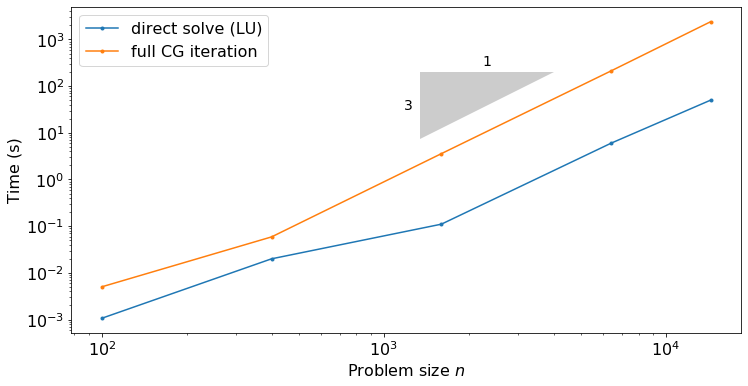

In [6]:
n = [100, 400, 1600, 6400, 14400]
t_cg= [0.00502013205550611, 0.05891977110877633, 3.5791730559431016, 212.58699144492857, 2392.833293305943]
t_solve= [0.001063752919435501, 0.019991094013676047, 0.11038840818218887, 6.008243826916441, 49.98688692296855]

plt.figure(figsize=(12,6))
plt.loglog(n, t_solve, '.-', label='direct solve (LU)')
plt.loglog(n, t_cg, '.-', label='full CG iteration')

annotation.slope_marker((4e3, 2e2), (3, 1), invert=True,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
plt.xlabel('Problem size $n$')
plt.ylabel('Time (s)')
plt.legend();

## Sparse Matrices
In the analysis above, we noted that the most expensive operation in a Conjugate Gradient iteration is the matrix-vector multiplication. For many applications this multiplication can be made a lot faster by using the fact that most entries of the matrix are in fact zero. These entries can simply be skipped since their multiplication with entries of the vector has no contribution to the product.

If we look closer at the matrix created for the finite difference discretisation of the Poisson problem:

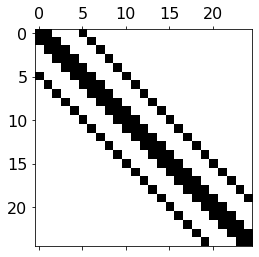

In [7]:
nx = 5
A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
# spy: display nonzero entries of the matrix
plt.spy(A);

we see that the matrix consists of 5 bands of nonzero entries. In the middle is the diagonal $\mat A_{i,i}, 0\leq i\leq n=N_x^2$. In addition there 4 off-diagonals: $\mat A_{i,i-1}$ and $\mat A_{i,i+1}$ representing connections between grid node $i$ and grid node $i-1$ and $i+1$ to the left and right, and $\mat A_{i,i-N_x}$ and $\mat A_{i,i+N_x}$ representing connections to grid node $i-N_x$ and $i+N_x$ in the row above and below. Instead of storing $\mat A$ in a $n\times n$ array, we could simply store the 5 diagonals seperately.

We implement this idea in the `DiagonalMatrix` below which allows the user to store a number of off-diagonals at different offsets from the main diagonal. in our case the offsets are $-N_x, -1, 0, 1,$ and $N_x$.

In [8]:
class DiagonalMatrix:
    def __init__(self, A, offsets):
        """Create a diagonal matrix from dense matrix A
        
        The (off-)diagonals are copied from A_i,i+j with j in offsets."""
        self.offsets = offsets
        self.diags = [np.diag(A, offset) for offset in self.offsets]
        self.n = A.shape[-1]
        
    def __matmul__(self, x):
        """This implements the matrix-vector multiplication A @ x"""
        Ax = np.zeros_like(x)
        for diag, offset in zip(self.diags, self.offsets):
            if offset>=0:
                Ax[:self.n-offset] += diag * x[offset:]
            else:
                Ax[-offset:] += diag * x[:self.n+offset]
        return Ax

# check that it works correctly
# by checking that the matrix vector product with a random vector
# is the same between our new matrix Adiag and the standard dense matrix (array) A
nx = 10
A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
Adiag = DiagonalMatrix(A, [-nx, -1, 0, 1, nx])
x = np.random.rand(nx*nx)
np.allclose(Adiag @ x, A @ x)

True

In [9]:
# do some timings to compare with dense matrix-vector multiplication
t_matvec_dense = []
t_matvec_diag = []
n = []
for nx in 20, 40,:  # expand this list to recreate the timings in the cell below
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    n.append(A.shape[0])
    Adiag = DiagonalMatrix(A, [-nx, -1, 0, 1, nx])
    time1 = timer()
    A @ b
    time2 = timer()
    Adiag @ b
    time3 = timer()
    t_matvec_dense.append(time2-time1)
    t_matvec_diag.append(time3-time2)
    
print(n)
print(t_matvec_dense)
print(t_matvec_diag)

[400, 1600]
[0.0026741439942270517, 0.01209895999636501]
[0.00034992198925465345, 0.0001956690102815628]


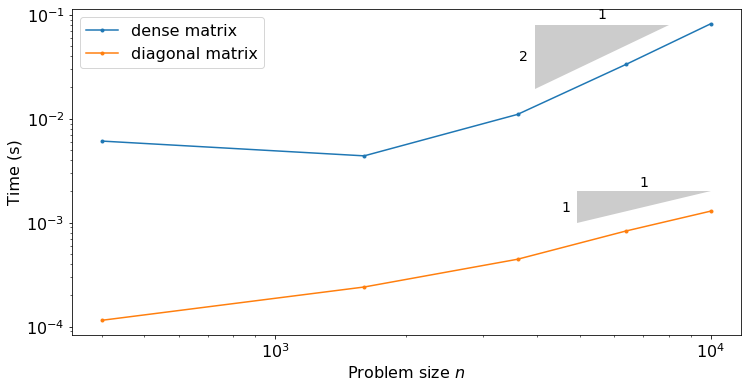

In [10]:
# plot some timings we have done previously
n = [400, 1600, 3600, 6400, 10000]
t_matvec_dense = [0.006096755001635756, 0.004395629002829082, 0.011013347000698559, 0.03345886199895176, 0.08203121199767338]
t_matvec_diag = [0.00011506100054248236, 0.00024046999897109345, 0.0004447559986147098, 0.0008334519989148248, 0.0012919000000692904]
plt.figure(figsize=(12,6))
plt.loglog(n, t_matvec_dense, '.-', label='dense matrix')
plt.loglog(n, t_matvec_diag, '.-', label='diagonal matrix')
annotation.slope_marker((8e3, 8e-2), (2, 1), invert=True,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e4, 2e-3), (1, 1), invert=True,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
plt.xlabel('Problem size $n$')
plt.ylabel('Time (s)')
plt.legend();

As we can observe the new matrix vector multiplication is much faster. In particular it is now a $O(n)$ operation instead of $O(n^2)$. This means the full Conjugate Gradient algorithm with $n$ iterations becomes just $O(n^2)$ instead of $O(n^3)$.

Another important reason to use a more compact matrix format is that it takes a lot less memory to store. With $N_x=100$ grid points in both directions, we have $n=10^4$ grid points in total. The associated matrix therefore consists of $n^2=10^8$ entries. If we take into account that each floating point number in double precision takes 8 bytes of memory, that means the dense matrix takes up ~ 800 MB. The 5 diagonals stored separately on the other hand take up only 400 kB.




## Poisson Problem on an Unstructured Mesh
To demonstrate what a matrix of discretisation based on an unstructured mesh might look like, we again look at Poisson's equation, but now in a slightly more complex geometry. We first set up the geometry:

In [11]:
"""Set up initial geometry in the form of a dictionary `geom` that contains the following entries:
    geom['vertices'] a list of the initial vertices on the boundaries
    geom['segments'] the edges making up the boundaries: 2-tuples of vertex numbers
    geom['holes']    any holes we want in the interior, specified by a location within each hole
    geom['vertex_marker'] a list of integers, one for each vertex to mark different parts of the boundary"""
nsegm = 20  # number of grid points on outer boundary
R2 = 2  # outer radius
outer_boundary = [[R2*np.cos(th), R2*np.sin(th)] for th in np.linspace(0, 2*np.pi, nsegm)]

from matplotlib.textpath import TextPath, FontProperties
fp = FontProperties(family="sans-serif", style="normal", weight='bold')
tp1=TextPath((-R2*0.7,-R2*0.1), r'ACSE', size=1, prop=fp)

def polys_to_geometry(polys):
    geom = {'vertices': [], 'segments': []}
    n = 0
    for poly in polys:
        geom['vertices'].extend(poly[:-1])
        geom['segments'].extend([(n+i, n+i+1) for i in range(len(poly)-2)] + [[n+len(poly)-2, n]])
        n += len(poly)-1
    return geom

polys = tp1.to_polygons() + [outer_boundary]
geom = polys_to_geometry(polys)

# add holes in the mesh, these can be specified by any point in that hole
# we choose these points here half-way the first edge, but slightly inside each of the polygons
geom['holes'] = []
for poly in polys[:-1]:
    dx = poly[1][0] - poly[0][0]
    dy = poly[1][1] - poly[0][1]
    geom['holes'].append((poly[0][0] + dx/2+dy/100, poly[0][1]+dy/2-dx/100))
    
# vertex markers are used to identify which points are on the boundary
# in the input geometry all vertices are on a boundary, so we simply set them all to 1
# after meshing, the new interior vertices will get a marker of 0
geom['vertex_markers'] = np.ones(len(geom['vertices']))

Then we use the [triangle mesh generator](https://www.cs.cmu.edu/~quake/triangle.html) to create a mesh. This isn't necessarily the most sophisticated mesh generator; we're using it here because it's easy to install (only need a `pip install triangle`):

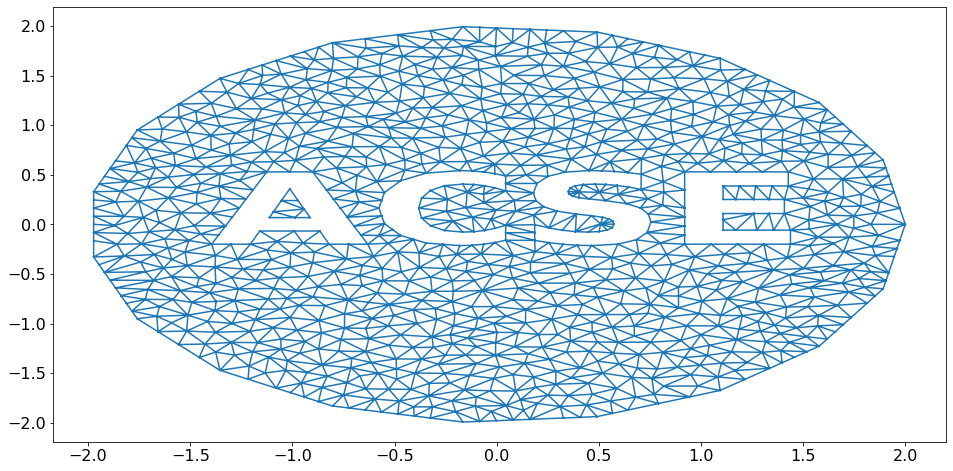

In [12]:
import triangle
tri = triangle.triangulate(geom, 'pDqa0.01')
x, y = tri['vertices'].T
fig, ax = plt.subplots(figsize=(16,8))
ax.triplot(x, y, tri['triangles']);

Because we want to use an unstructured mesh, we choose a finite element discretisation. The implementation here is kept simple by choosing piecewise linear continuous basis functions (P1), and assuming a zero righthand side (Laplace's equation): $\nabla^2 u=0$. We then solve it in the following equation in weak form:
$$
  \text{solve } \int \nabla\Phi_i \cdot \nabla u = 0 \text{ for all } \Phi_i\in \text{P1, with } u=\sum_j u_j\Phi_j 
$$
where we have integrated by parts the Laplace term on the left-hand side (for more details see ACSE-3). By substituting the expansion of $u$, this turns in to a linear system
$$
  \text{solve } \sum_j \mat A_{ij}u_j = \sum_j \int \nabla\Phi_i \cdot \nabla \Phi_j ~ u_j = 0
$$
In the implementation below the entries $\mat A_{ij}$ of the matrix are worked out using geometric identities. In addition we implement boundary conditions which impose a value of $u=1$ on the interior boundary, and $u=0$ on the outside boundary.

In [13]:
def Poisson_2D_Dirichlet_FE(vertices, triangles, vertex_markers=None, f_rhs=None, DBC=None):
    n = len(vertices)
    A = sp.lil_matrix((n, n))
    d = [0,0,0]
    for tri in triangles:
        xy = vertices[tri]
        # squared edge lengths:
        d[0] = sum((xy[1]-xy[2])**2)
        d[1] = sum((xy[0]-xy[2])**2)
        d[2] = sum((xy[0]-xy[1])**2)
        dsum = sum(d)
        # triangle area times 8:
        A8 = ((xy[1,0]-xy[0,0])*(xy[2,1]-xy[0,1]) - (xy[2,0]-xy[0,0])*(xy[1,1]-xy[0,1]))*4
        for i, di in zip(tri, d):
            A[i,i] += 2*di/A8
            for j, dj in zip(tri, d):
                if i==j:
                    continue
                A[i,j] += (dsum - 2*(di + dj))/A8
                
    b = np.zeros(n)
    if f_rhs is not None:
        raise NotImplementedError("Poisson_2D_Dirichlet_FE currentl only supports 0 rhs")
        
    if DBC is None:
        return A, b
    
    boundary_nodes = np.arange(n)[(vertex_markers>0).flatten()]
            
    bval = np.zeros(n)
    x, y = vertices.T
    for i in boundary_nodes:
        bval[i] = DBC(x[i], y[i])
    # lift contribution of boundary values to other rows to rhs:
    b = b - A @ bval
    # take out boundary row and columns, put 1 on diagonal and substitute with boundary value
    for i in boundary_nodes:
        A[i,:] = 0.
        A[:,i] = 0.
        A[i,i] = 1.
        b[i] = bval[i]
        
    return A.tocsr(), b
    
def DBC_simple(x,y):
    r = np.sqrt(x**2+y**2)
    if r>0.9*R2:
        return 0
    else:
        return 1

A, b = Poisson_2D_Dirichlet_FE(tri['vertices'], tri['triangles'], tri['vertex_markers'], DBC=DBC_simple)

As in the finite difference case, the finite element discretisation results in a SPD linear system and therefore we can solve it using Conjgate Gradient:

In [14]:
sol, info = spl.cg(A, b)

The solution, a value for each vertex in the mesh, can be plotted with `tripcolor`:

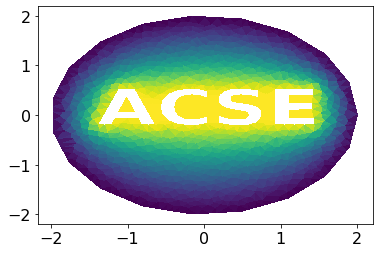

In [15]:
x, y = tri['vertices'].T
plt.tripcolor(x, y, tri['triangles'], sol);

## Storing General Sparse Matrices in Compressed Sparse Row (CSR) Format
If we look at the nonzero pattern of the matrix we have just created, it looks, as expected, fairly unstructured outside the main diagonal. The matrix is still very sparse however, so we can still make a large saving by only storing the nonzero entries, and looping over these in a matrix vector multiplication.

Matrix has 5192 nonzero entries out of 1085764, which is 5.0 per row on average


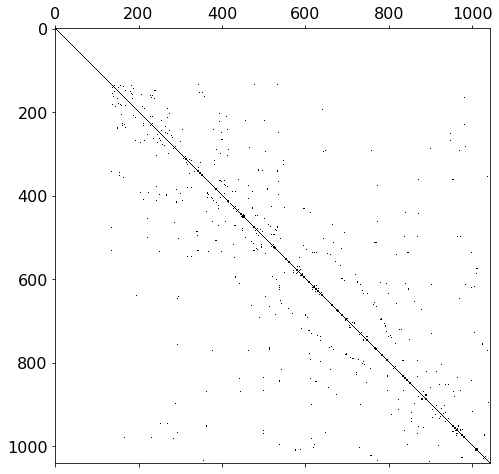

In [16]:
plt.figure(figsize=(16,8))
plt.spy(A.todense())
print("Matrix has {} nonzero entries out of {}, which is {:.1f} per row on average".format(
        A.getnnz(), np.product(A.shape), A.getnnz()/A.shape[0]))

The way such more general sparse matrices are stored is by storing all nonzero values in one long array of floats (here accessible as `A.data`). To keep track of where these nonzero entries are located in the matrix two integer arrays of the same length are stored: `row`, which stores the row number of each entry, and `col`, which stores the column number of each entry.

In [17]:
m = 37
row, col = A.nonzero()
print('Last {} nonzero entries'.format(m))
print('Values:', A.data[-m:])
print('Row numbers:', row[-m:])
print('Column numbers:', col[-m:])

Last 37 nonzero entries
Values: [-0.52627701 -0.28181575 -0.49710848 -0.28776765  3.51370213 -0.8368068
 -0.88786686 -1.08908029 -0.8368068   4.04797703 -0.63915957 -0.51879947
 -0.43898644 -0.86332701 -0.11197065 -0.14321377 -0.45095935 -0.3281883
  3.49460456 -0.5732523  -0.51180362 -0.62507001 -0.47560904 -0.48557483
 -0.03830633  3.58075408 -0.87113795 -0.40585263 -0.51350358 -0.53343865
 -0.59664634 -0.61377294 -0.87113795  3.5343521   1.          1.
  1.        ]
Row numbers: [1034 1034 1034 1034 1034 1034 1035 1035 1035 1035 1036 1036 1036 1036
 1036 1036 1036 1036 1036 1037 1037 1037 1037 1037 1037 1037 1037 1038
 1038 1038 1038 1038 1038 1038 1039 1040 1041]
Column numbers: [ 969  973  974  975 1034 1035  973 1032 1034 1035  355  411  460  768
  769  771  772  773 1036  730  886  895  900  901  919 1037 1038  886
  895  896  897  898 1037 1038 1039 1040 1041]


As you can see, the entries are stored in order: first by row, and then within each row by column number. This reduces the amount of time it takes to look up the corresponding vector entries in memory. This is caused by the way modern memory systems operate: entries that have been accessed recently are cached and can be retrieved more quickly. Since the column entries in a row typically refer to nearby nodes, processing the rows in order increases the chance of these nearby entries still being "in cache".

It also means we can make a further saving, as there is a lot of repetition in the array of row numbers `row`. Instead of storing the row number for each *entry*, we can store for each *row* the index in the `A.data` and `col` arrays at which each row starts. The end of each row is then also known, as the row ends one entry before the next row starts. The array of these starting indices (here called `indptr`) only has $n$ entries which is generally a lot smaller than the number of nonzero entries.

In [18]:
l = 8
n = A.shape[0]
col = A.indices  # the array of column indices is available as A.indices
print('Print the last {} rows:'.format(l))
for i in range(n-l, n):
    start = A.indptr[i]
    end = A.indptr[i+1]  # row ends one entry before the next row starts
    print('Row {}: columns = {}, values={}'.format(i, col[start:end], A.data[start:end]))

Print the last 8 rows:
Row 1034: columns = [ 969  973  974  975 1034 1035], values=[-0.52627701 -0.28181575 -0.49710848 -0.28776765  3.51370213 -0.8368068 ]
Row 1035: columns = [ 973 1032 1034 1035], values=[-0.88786686 -1.08908029 -0.8368068   4.04797703]
Row 1036: columns = [ 355  411  460  768  769  771  772  773 1036], values=[-0.63915957 -0.51879947 -0.43898644 -0.86332701 -0.11197065 -0.14321377
 -0.45095935 -0.3281883   3.49460456]
Row 1037: columns = [ 730  886  895  900  901  919 1037 1038], values=[-0.5732523  -0.51180362 -0.62507001 -0.47560904 -0.48557483 -0.03830633
  3.58075408 -0.87113795]
Row 1038: columns = [ 886  895  896  897  898 1037 1038], values=[-0.40585263 -0.51350358 -0.53343865 -0.59664634 -0.61377294 -0.87113795
  3.5343521 ]
Row 1039: columns = [1039], values=[1.]
Row 1040: columns = [1040], values=[1.]
Row 1041: columns = [1041], values=[1.]


The entire matrix can thus be stored in three arrays: `A.data` and `A.col` storing the values and column indices for each non-zero entry, and `A.indptr` storing the starting index for each row. This data structure is called Compressed Sparse Row (CSR). The `scipy.sparse` module offers it as [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). It implements many of the same methods that a normal dense $n\times n$ numpy array offers, for instance multiplication `A @ b`, access to individual entries by indexing `A[i,j]`, etc. This means that you can use a `csr_matrix` in much the same way as a matrix in the form of a dense numpy array.

When setting values in a `csr_matrix`, however you have to be careful. When creating a new `csr_matrix` it is assumed to be completely zero, and thus the `A.data` and `A.col` arrays start at zero length. When entering new nonzero entries, new entries are inserted in these arrays, and since these arrays need to be kept ordered this requires shifting up existing entries which is very slow. When assembling a new sparse matrix it is therefore better to start it as a [`lil_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) which is more flexible, but is slower in performing arithmetic operations such as a matrix-vector product. When the matrix assembly is finished, we therefore want to convert it (using the `.tocsr()` method) to a `csr_matrix` before we start solving the system.

In [19]:
M = sp.lil_matrix((5,5))  # start M as a zero 5x5 matrix
# add some new nonzero entries:
M[1,2] = 1.0
M[3,1] = -1.0
print(M.todense())  # print the dense matrix
# convert to csr_matrix:
M_csr = M.tocsr()
# access some entries of the CSR matrix:
M_csr[1,2], M_csr[3,1], M_csr[4,4]

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


(1.0, -1.0, 0.0)

Finally we show that, next to a saving in memory sparse matrix formats also provide a significant reduction in the time it takes to perform arithmetic operations:

In [20]:
# we assume here that A is a csr_matrix produced by Poisson_2D_Dirichlet_FE
assert type(A) == sp.csr_matrix
A_lil = A.tolil()  # convert back to lil_matrix
# convert to dense - NOTE this is only possible for very coarse resolutions;
# when increasing the resolution this will run out of memory very soon
A_dense = A.todense()
# we multiply with the RHS vector, which doesn't really mean anything but it is good enough for testing purposes
time1 = timer()
A_dense @ b
del A_dense
time2 = timer()
A_lil @ b
time3 = timer()
A @ b
time4 = timer()

print("Time taken by dense matrix-vector product:", time2-time1)
print("Time taken by lil_matrix-vector product:", time3-time2)
print("Time taken by csr_matrix-vector product:", time4-time3)

Time taken by dense matrix-vector product: 0.0038332489784806967
Time taken by lil_matrix-vector product: 0.002392951981164515
Time taken by csr_matrix-vector product: 0.00014948996249586344


## Complexity of LU decomposition
In the complexity analysis above, we showed that for sparse linear systems the complexity of a (naive) direct method on general dense matrices was $O(n^3)$. This is based on the fact that we need to do $O(n^2)$ row operations which are $O(n)$ each. It now seems that with sparse matrices iterative methods can achieve much better complexity since with an $O(n)$ matrix-vector product, the cost of one iteration can typically be reduced to $O(n)$ as well.

The performance of direct methods however can also be improved by taking the sparsity of the matrix into account but this is less straightforward. Initially the work is greatly reduced; for instance in the `Gaussian_elimination_upper` routine we still have an outer loop over all rows, but for each of these we only need to subtract it from rows below that have a corresponding nonzero column entry. Each row operation on its own is initially much cheaper as well as there are only a limited number of entries to work on. After some operations however, the matrix will acquire new nonzero entries (these are called <a class="definition" href="#definitions" id="fillin">fill-in</a>) and slowly the matrix starts becoming dense so that the cost converges to that for dense matrices.

As an example let's have a look at the fill-in when we derive a $LU$-decomposition of the matrix associated with the finite difference Poisson problem. For this we use the `splu` function in `scipy.linalg`.

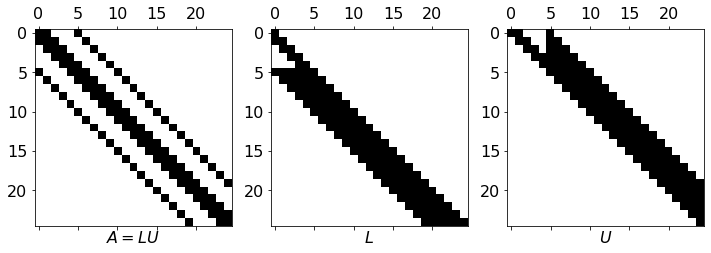

In [21]:
nx = 5
A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
# splu uses the SuperLU library to construct a LU-decomposition
# it returns a SuperLU matrix Ainv that represents the inverse of A
# that means we afterwards we can simply do Ainv @ b to solve Ax=b (x=A^{-1}b)
# to perform this product it then uses the LU-decomposition that is stored on
# Ainv as Ainv.L and Ainv.U
# by default SuperLU applies a reordering (permutation) of rows and columns to try
# to reduce the fill-in. In this structured mesh example however, the 'natural' ordering 
# (i.e. we don't change the order) is the best
Ainv = spl.splu(sp.csc_matrix(A), permc_spec='natural')

fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].spy(A)
ax[0].set_xlabel("$A=LU$")
ax[1].spy(Ainv.L.todense())
ax[1].set_xlabel("$L$")
ax[2].spy(Ainv.U.todense())
ax[2].set_xlabel("$U$");

<div class="optional">
As we can see the fill-in occurs between the initially furthest apart non-zero entries: $L_{ij}\neq 0$ for all $i-N_x\leq j\leq i$ and $U_{ij}\neq 0$ for all $i\leq j\leq i+N_x$. This means that the cost of the LU decomposition itself is roughly $O(n \times N_x \times N_x)=O(n^2)$. Once we have obtained the LU decomposition however it becomes cheaper to apply the inverse to multiple right-hand sides, i.e. solve $\mat L\mat U \vec x=\vec b$ for multiple vectors $\vec b$, since each of these solves is only $O(n \times N_x)=O(n^{1.5})$.

Note that this complexity analysis is specific for the 2D problem that we are solving. For instance if we were solving the same problem in 3D with $n=N_x\times N_y\times N_z$ the complexity would be $O(n\times (N_x\times N_y)^2)=O(n^{2.333})$ for the constructing the LU decomposition and $O(n\times N_x\times N_y)=O(n^{1.666})$ for a subsequent solve of $\mat L\mat U\vec x=\vec b$.

The situation is worse for our unstructured example.
</div>

Number of nonzero entries in L and U: 43795


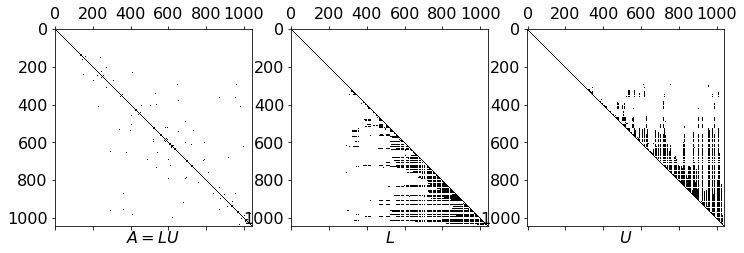

In [22]:
A, b = Poisson_2D_Dirichlet_FE(tri['vertices'], tri['triangles'], tri['vertex_markers'], DBC=DBC_simple)
Ainv = spl.splu(sp.csc_matrix(A), permc_spec='natural')

fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].spy(A.todense())
ax[0].set_xlabel("$A=LU$")
ax[1].spy(Ainv.L.todense())
ax[1].set_xlabel("$L$")
ax[2].spy(Ainv.U.todense())
ax[2].set_xlabel("$U$");

print("Number of nonzero entries in L and U:", Ainv.L.nnz)

<div class="optional">
Since in an unstructured mesh the connections to neighbouring degrees of freedom are irregular, the spread of nonzero entries in the initial matrix $\mat A$, and therefore the fill-in in the matrices $\mat L$ and $\mat U$ is much larger. This problem can be reduced somewhat by applying a reordering of the matrix.
</div>

Number of nonzero entries in L and U: 10442


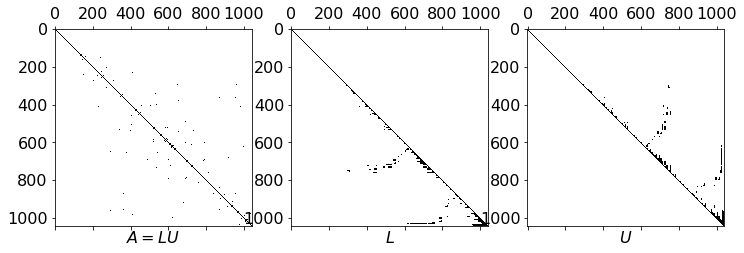

In [23]:
A, b = Poisson_2D_Dirichlet_FE(tri['vertices'], tri['triangles'], tri['vertex_markers'], DBC=DBC_simple)
Ainv = spl.splu(A.tocsc(), permc_spec='colamd')

fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].spy(A.todense())
ax[0].set_xlabel("$A=LU$")
ax[1].spy(Ainv.L.todense())
ax[1].set_xlabel("$L$")
ax[2].spy(Ainv.U.todense())
ax[2].set_xlabel("$U$");

print("Number of nonzero entries in L and U:", Ainv.L.nnz)

## Complexity of Truncated Methods
So far we have treated the Conjugate Gradient method as an algorithm that returns the exact solution in $n$ iterations. It turns out however, that the method is so efficient at reducing the residual that for almost any practical application far fewer iterations are needed, since we only care about the answer up to a certain precision.

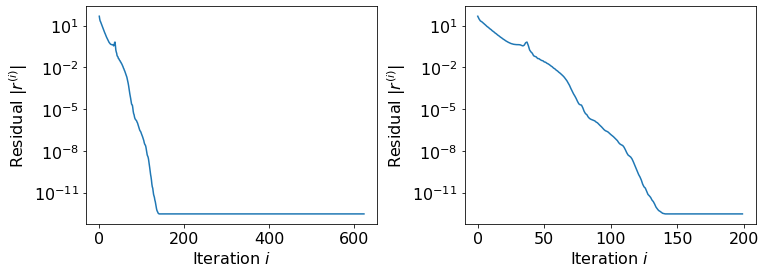

In [24]:
nx = 25
A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)

# we define a ResidualMonitor class, that can be used as a callback
# for scipy's cg, every iteration it is called with the current x^k
# we compute the current residual and add it to a list, so we can plot
# afterwards

class ResidualMonitor:
    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.residuals = []
        
    def __call__(self, x):
        self.residuals.append(sl.norm(self.b - self.A @ x))

monitor = ResidualMonitor(A, b)
        
x, info = spl.cg(A, b, tol=0, atol=0, callback=monitor, maxiter=nx*nx)
fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)
ax[0].semilogy(monitor.residuals)
ax[0].set_xlabel('Iteration $i$')
ax[0].set_ylabel('Residual $\|r^{(i)}\|$')

ax[1].semilogy(monitor.residuals[:200]);
ax[1].set_xlabel('Iteration $i$')
ax[1].set_ylabel('Residual $\|r^{(i)}\|$');

In fact, if we look at the convergence of the residual in the 2-norm $\|\vec r^{(i)}\|$ in the figure above (left and right; right figure zooms in on the first 200 iterations) we see that after only 150 iterations we have reduced the residual so far that we have hit machine precision, and there is no point in any further iterations.

As discussed in the previous lecture, for practical applications we impose a stopping criterion to control how much the residual should be reduced to terminate the iteration. To understand the complexity of a solve with a stopping criterion we therefore need to estimate how many iterations are required to reach this criterion.

The convergence of the residual, and the actual error $\vec x^*-\vec x^{(i)}$, can be studied by decomposing the initial residual vector into the eigenvectors of the matrix. For SPD matrices the analysis is simplified by the fact that we know there is a complete basis of orthogonal eigenvectors, and that all eigenvalues are positive.
More details can be found in [Shewchuck '94](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf). Here we will simply quote the results of this analysis for Steepest Descent and Conjugate Gradient methods, which state that a reduction of the error in the $\mat A$-norm

$$
  \| \vec x^{(*)} - \vec x^{(i)}\|_{\mat A} \lt \epsilon \| \vec x^{(*)} - \vec x^{(i)}\|_{\mat A}
$$

can be achieved with the following bounds on the number of required iterations

\begin{align*}
  i &\leq \tfrac 12 \kappa(\mat A) \ln \tfrac 1\epsilon & \text{ for Steepest Descent} \\
  i &\leq \tfrac 12 \sqrt{\kappa(\mat A)} \ln \tfrac 2\epsilon & \text{ for Conjugate Gradient}
\end{align*}

where $\kappa(\mat A) = \lambda_{\text max}/\lambda_{\text min}$ is the condition number of the matrix: the ratio of the largest and smallest eigenvalue.

If we're using sparse matrices, so that the cost of each iteration is $O(n)$, this means that the cost of the entire algorithm can now be classified as $O(\kappa n)$, resp. $O(\sqrt{\kappa} n)$  for Steepest Descent and Conjugate Gradient. Note that the convergence criterion we have used here is not the same as a criterion for the relative reduction of the residual that we use in practice. The actual complexity is therefore subtly different (worse for large $\kappa$), but we will ignore this here.

<div class="optional">
For some experiments to confirm this analysis, we return to the finite difference Poisson problem. We first make a small modification to `Poisson_2D_Dirichlet_FD` to produce a sparse matrix instead of a dense matrix. In particular we use `scipy.sparse`'s `dia_matrix` which allows efficient storage of banded matrices, i.e. a matrix with a fixed number of (off-)diagonals, in this case 5 - typical for structured mesh calculations (similar to the incomplete implementation `DiagonalMatrix` we defined above). We make this change in `Poisson_2D_Dirichlet_FD` rather than just converting to a sparse matrix afterwards, because we may run out of memory for larger grids.
</div>

In [25]:
def Poisson_2D_Dirichlet_FD(Nx, Ny, RHS_F, DBC, Lx=1.0, Ly=1.0, dtype='float64'):
    """ Form/assemble the discretised Poisson problem in 2D 
    using second-order finite differences,
    with the RHS function given by RHS_F 
    and Dirichlet boundary conditions given in the function DBC.
    """
    dx = Lx/(Nx+2)
    dy = Ly/(Ny+2)
    X = np.arange(0, Nx)*dx + dx
    Y = np.arange(0, Ny)*dy + dy
    
    # evaluate rhs in grid points
    rhs = np.empty((Nx, Ny), dtype=dtype)
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            rhs[i, j] = RHS_F(x,y)
            
    # construct matrix from 5 (off-)diagonals
    # we provide the diagonals as one 5 x n array
    # the actual off-diagonals should of course be shorter
    # but dia_matrix cuts them off for us
    n = Nx*Ny
    offsets = [-Nx, -1, 0, 1, Nx]
    diags = -np.ones((5,n))/dx**2
    diags[2] = -diags[2]*4  # main diagonal should be positive and 4 times the off-diagonals
    A = sp.dia_matrix((diags, offsets), shape=(n,n))
    
    # lift boundary condition values
    rhs[0, :] += DBC(X, 0.0)/dx**2  # bottom values
    rhs[-1, :] += DBC(X, Ly)/dx**2  # top values
    rhs[:, 0] += DBC(0.0, Y)/dx**2  # left values
    rhs[:, -1] += DBC(Lx, Y)/dx**2  # right values
    
    return A, rhs.flatten()

<div class="optional">
Then we do some timing experiments with different resolutions specified by the number $N_x$ of grid points in each direction. For the total number of degrees of freedom: $n=N_x^2$. We solve the systems with Steepest Descent and Conjugate Gradient - both using a relative tolerance of 1e-5.

Here's our implementation of Steepest Descent:
</div>

In [26]:
def steepest_descent(A, b, rtol=1e-5):
    """Simple Steepest Descent method with zero initial guess and relative tolerance"""
    x = np.zeros_like(b)  # start with zero initial guess
    r = b - A @ x
    r0 = sl.norm(r)  # norm of initial residual
    it = 0
    while sl.norm(r)>rtol*r0:
        alpha_star = np.dot(r, r)/np.dot(r, A @ r)
        x = x + alpha_star*r
        r = b - A @ x
        it += 1
    
    return x, it

<div class="optional">
For Conjugate Gradient we use scipy's implementation `spl.cg`. Unfortunately it does not report back how many iterations it has used to re8ach the (relative) stopping critertion. It does however allow you to provide a callback, a function that it will call every iteration. For this callback we will provide a `SimpleCounter` object based on the class below. It is an object that simply counts the number of times it has been called (ignoring any other arguments it may have been given):
</div>

In [27]:
class SimpleCounter:
    """Simple counter object that records how many times it has been called"""
    def __init__(self):
        self.count = 0
    
    def __call__(self, *args):
        """Counts each call, ignore any arguments"""
        self.count += 1


# example usage:
counter = SimpleCounter()
counter()
counter("spurious argument", [1, 2, 3])
# we have called it twice now:
assert counter.count == 2

<div class="optional">
Finally the code that times Steepest Descent and Conjugate Gradient applied to the Poisson
problems on meshes of increasing size:
</div>

In [28]:
t_sd = []
t_cg = []
its_sd = []
its_cg = []
n = []
for nx in 40, 80: # 160, 320, 640: # expand this to reproduce the timings plotted in the next cell
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    time1 = timer()
    x, it_sd = steepest_descent(A, b)
    time2 = timer()
    counter = SimpleCounter()
    x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter)
    time3 = timer()
    t_sd.append(time2-time1)
    t_cg.append(time3-time2)
    its_sd.append(it_sd)
    its_cg.append(counter.count)
    n.append(A.shape[0])
    
print("Degrees Of Freedom:", n)
print("Timings Steepest Descent:", t_sd)
print("Timings Conjugate Gradient:", t_cg)
print("Iterations Steepest Descent:", its_sd)
print("Iterations Conjugate Gradient:", its_cg)

Degrees Of Freedom: [1600, 6400]
Timings Steepest Descent: [0.13964134105481207, 0.5541290940018371]
Timings Conjugate Gradient: [0.004771049018017948, 0.010961927007883787]
Iterations Steepest Descent: [3111, 7354]
Iterations Conjugate Gradient: [105, 174]


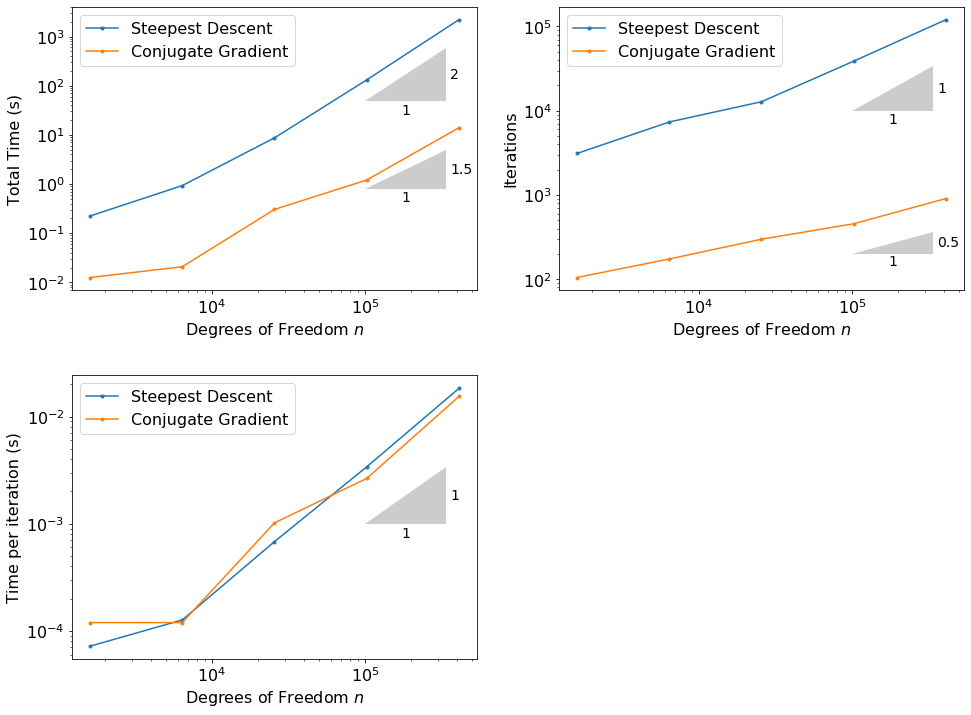

In [29]:
# these results were obtained earlier
n = [1600, 6400, 25600, 102400, 409600]
t_sd = [0.22358962999715004, 0.929597759997705, 8.69946387001255, 131.54660375899402, 2206.4073799010075]
t_cg = [0.012539653005660512, 0.020767997004440986, 0.3044052179902792, 1.206662315002177, 13.987541098991642]

its_sd = [3111, 7354, 12785, 38758, 120365]
its_cg = [105, 174, 299, 456, 908]

fig, ax = plt.subplots(2,2,figsize=(16,12))
fig.subplots_adjust(hspace=0.3)
t_sd = np.array(t_sd)
t_cg = np.array(t_cg)
ax[0,0].loglog(n, t_sd, '.-', label='Steepest Descent')
ax[0,0].loglog(n, t_cg, '.-', label='Conjugate Gradient')
ax[0,0].set_xlabel('Degrees of Freedom $n$')
ax[0,0].set_ylabel('Total Time (s)')
annotation.slope_marker((1e5, .8), (1.5, 1), ax=ax[0,0],
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e5, 50), (2, 1), ax=ax[0,0],
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

ax[0,0].legend();

ax[0,1].loglog(n, its_sd, '.-', label='Steepest Descent')
ax[0,1].loglog(n, its_cg, '.-', label='Conjugate Gradient')
ax[0,1].set_xlabel('Degrees of Freedom $n$')
ax[0,1].set_ylabel('Iterations')
annotation.slope_marker((1e5, 200), (0.5, 1), ax=ax[0,1],
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e5, 1e4), (1, 1), ax=ax[0,1],
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax[0,1].legend();

ax[1,0].loglog(n, t_sd/its_sd, '.-', label='Steepest Descent')
ax[1,0].loglog(n, t_cg/its_cg, '.-', label='Conjugate Gradient')
annotation.slope_marker((1e5, 1e-3), (1, 1), ax=ax[1,0],
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax[1,0].set_xlabel('Degrees of Freedom $n$')
ax[1,0].set_ylabel('Time per iteration (s)')
ax[1,0].legend();

ax[1,1].remove()

<div class="optional">
As we can see from the results (top left figure), when we increase $n$ the time it takes for both methods to reach the desired accuracy increases more than linearly with $n$. This is caused by an increased number of iterations (top right figure); the cost *per iteration* (bottom left) does scale, as expected for sparse matrices, linearly with $n$. The reason the required number of iteration increases, is that the condition number of the matrix also increases with increasing $n$. This is typical for many applications, in particular for numerical models of PDEs. In the following section, we will therefore look at techniques to reduce the condition number of the matrix (preconditioning).
</div>

## Condition Number Estimates for the Discrete Laplace Operator (*)  <a class="tocSkip"></a>
<div class="optional">
   
$\newcommand\ddx[1]{\frac{\mathrm{d}^2 #1}{\mathrm{d}x^2}}$
For an estimate of the eigenvalues of the matrix of the discretised Poisson problem, we can look at the eigenvalues of the continuous problem: $-\nabla^2 u = 0$. First let us consider the 1D Poisson problem $-\ddx{u(x)}=f$ in a domain given by $0\leq x\leq L$. The eigenfunctions of the $-\ddx{}$- operator are of the form
$$
  u(x) = \sin(kx), \text{ or }u(x) = \cos(kx)
$$
since
$$
  -\ddx{\sin(kx)} = k^2 \sin(kx) \text{ and } -\ddx{\cos(kx)} = k^2 \cos(kx)
$$
Here $k$ represent the wave number with $k=2\pi/l$ where $l$ is the wave length. The eigenvalues $\mu$ of this problem thus take the following form:
$$
  \mu = k^2 = \frac{4\pi^2}{l^2}
$$
Large wave lengths $l$ thus correspond with small eigenvalues, and vice versa. After discretisation we expect the eigenvectors of the matrix to correspond with a numerical approximation of these eigenfunctions with the corresponding (approximate) eigenvalue (\*). The smallest wave lengths that can be resolved then correspond with the largest eigenvalues and $\mu_{\text max} \propto 1/\Delta x^2$. The largest wave lengths are determined by the size $L$ of the domain, and assuming sufficient resolution to represent these, their associated smallest eigenvalues are not expected to change much when further increasing the resolution. Therefore we should expect the condition number of the discretised system to scale according to
$$
  \kappa(\mat A) = \frac{\mu_{\text max}}{\mu_{\text min}} \propto \frac 1{\Delta x^2}
$$
The same conclusion can be drawn after a similar analysis in multiple dimensions (assuming $\Delta x=\Delta y$).
<br/>
<br/>
(*) <it>This assumes $\mat A\sim -\nabla^2$, as it is in our FD experiments. Often however there is a scaling of $\mat A$ with respect to the continuous operator $-\nabla^2$ which might involve $\Delta x$. For instance we could have multiplied both $\mat A$ and $\vec b$ with $\Delta x^2$ and obtained the same solutions (this gets rid of all the $\Delta x$-factors in the matrix). In this case it would be the smallest eigenvalues that are proportional to $\Delta x^2$ with the largest eigenvalues unchanged. This however does not change the condition number.</it>
<br/>
<br/>
Combining this with the fact that in our problem $\Delta x=L/N_x$, we get $\kappa(\mat A)\propto N_x^2=n$, i.e. the condition number scales linearly with $n$. The combined complexities for the Steepest Descent and Conjugate Gradient algorithm applied to a discretised Poisson problem are thus respectively $O(n^{3/2})$ and $O(n^2)$.
</div>

In [30]:
# calculate the condition number for different resolutions
# NOTE: this is not necessarily very accurate, accurate
# eigenvalue estimation is expensive
kappa = []
n = []
for nx in 10, 20, 40, 80, 160:
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    w1, v1 = spl.eigsh(A, k=1, tol=0.1)  # ask for largest eigenvalue only
    w2, v1 = spl.eigsh(A, k=1, tol=0.1, which='SA')  # ask for smallest eigenvalue only
    kappa.append(w1[0]/w2[0])
    n.append(A.shape[0])
    
print("n =", n)
print("kappa =", kappa)

n = [100, 400, 1600, 6400, 25600]
kappa = [93.16736706989292, 351.67948105742664, 1350.068461969711, 5288.558764624422, 20924.45253142647]


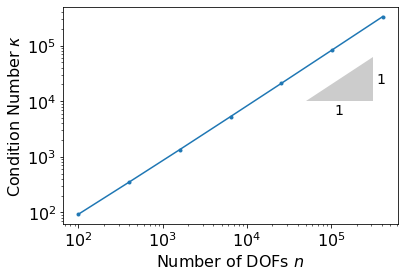

In [31]:
n = [100, 400, 1600, 6400, 25600, 102400, 409600]
kappa = [93.13932432595148, 351.9747191804715, 1353.8648652078227, 5297.002600817822, 20919.206553270866, 83219.29143909109, 331901.9563853423]
plt.loglog(n, kappa, '.-')
plt.xlabel('Number of DOFs $n$')
plt.ylabel('Condition Number $\kappa$')
annotation.slope_marker((5e4, 1e4), (1, 1),
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

## Summary: comparing direct methods with Conjugate Gradient
In this section, we have discussed a number of improvements in both direct and iterative methods to improve the scaling of the computational cost with problem size $n$:

* both direct and indirect methods can be improved through the use of sparse matrices if the underlying matrix structure of the linear system is sparse. In the case of direct methods however, because of the issue of fill-in, the saving depends a lot on the type of problem with more savings for problems based on a 2D grid than problems based on a 3D grid
* in practice iterative methods are always truncated, which makes their cost dependent on the number of iterations required to achieve a certain stopping criterion. For many algorithms, the required number of iterations depends on the condition number of the matrix. In turn, for discretised problems the condition number depends on mesh resolution. Thus increasing the mesh resolution not only increases the number of DOFs $n$, but also the number of iterations.

Whether direct methods or iterative methods are more efficient is thus very problem specific. As a general rule for many 2D discretised problems, direct methods can be competitive, but in 3D discretisations iterative methods are typically much more efficient.

# Preconditioning
The performance of the methods we have discussed so far seem strongly dependent on the condition number which is undesirable as for many problems the condition number increases with problem size. In this section we will discuss some techniques to improve the situation. First we revisit two iterative methods that were already presented in ACSE-3: the Jacobi and Gauss-Seidel methods

## Jacobi and Gauss-Seidel revisited
First we introduce the following decomposition of the matrix
$$
  \mat A = \mat D + \mat L + \mat U
$$
where $\mat D$ contains only the diagonal of matrix $\mat A$, $\mat L$ contains only the entries *below* the diagonal (the Lower diagonal part of the matrix), and $\mat U$ the entries *above* the diagonal (the Upper diagonal part). Note that these are different matrices $\mat L$ and $\mat U$ than those used in a LU-decomposition in which $\mat A=\mat L \mat U$ where we multiply $\mat L$ and $\mat U$.

<div class="optional">
The <a class="definition">Jacobi method</a> to solve $\mat A\vec x=\vec b$ is described by the idea that to obtain the next approximation $\vec x^{(k+1)}$, we only use the new value $\vec x^{(k+1)}$ when multiplying with the diagonal of $\mat A$, and use the previous value $\vec x^{(k)}$ otherwise.

That means we solve:

$$
  \mat D \vec x^{(k+1)} + \left[\mat L + \mat U\right] \vec x^{(k)} = \vec b,
$$

and since $\mat D$ is easily invertible we get:

$$
  \vec x^{(k+1)} = {\mat D}^{-1} \left[\vec b - \left[\mat L + \mat U\right] \vec x^{(k)} \right].
$$

Similarly in the <a class="definition">Gauss-Seidel method</a>, we only use the new values $\vec x^{(k+1)}$ when multiplying with the diagonal and lower diagonal

$$
  \left[\mat D + \mat L\right] \vec x^{(k+1)} + \mat U \vec x^{(k)} = \vec b.
$$

This can be solved easily row, by row. For the first row, we only need to solve for the first entry of $\vec x^{(k)}$:

$$
  \mat D_{00} \vec x^{(k+1)}_0 + \sum_{j \gt 0} \mat U_{0j} \vec x^{(k)}_0 = \vec b_0
$$

For any subsequent row $i$ we do need the new entries $\vec x^{(k+1)}_j$ for $j \lt i$, but these were already computed in the previous rows. Thus again we only have one entry $\vec x^{(k+1)}_i$ to solve for:

$$
  \mat D_{ii} \vec x^{(k+1)}_i + \sum_{j \lt i} \mat L_{ij} \vec x^{(k+1)}_j + \sum_{j \gt i} \mat U_{ij} \vec x^{(k)}_j = \vec b_i
$$

It has proven useful to express the update $\vec x^{(k)}\to\vec x^{(k+1)}$ in terms of the residual $\vec r^{(k)}=\vec b -  \mat A\vec x^{(k)}$. For the Jacobi method we may write:

\begin{align*}
  \vec x^{(k+1)} &= {\mat D}^{-1} \left[\vec b - \left[\mat L + \mat U\right] \vec x^{(k)} \right]
     - {\mat D}^{-1}\mat D\vec x^{(k)} + {\mat D}^{-1}\mat D\vec x^{(k)} \\
     &= \vec x^{(k)} + {\mat D}^{-1}\left[\vec b - \left[\mat L + \mat U + \mat D\right]\vec x^{(k)}\right] \\
     &= \vec x^{(k)} + {\mat D}^{-1}\vec r^{(k)}
\end{align*}

In the same way we may derive that for the Gauss-Seidel method:
$$
\vec x^{(k+1)} = \vec x^{(k)} + \left[\mat D + \mat L\right]^{-1}\vec r^{(k)}
$$
</div>

We can thus write both the <a class="definition" href="#definitions" id="Jacobimethod">Jacobi method</a> and the <a class="definition" href="#definitions" id="GaussSeidelMethod">Gauss Seidel method</a> methods as

$$
\vec x^{(k+1)} = \vec x^{(k)} + \mat M^{-1}\vec r^{(k)}
$$

where $\mat M=\mat D$ for Jacobi and $\mat M=\mat D + \mat L$ for Gauss-Seidel. This places both methods in a broader class of methods that approximate $\mat A$ with a matrix $\mat M$ that is easily invertible. This is based on the idea that

$$
  \mat M^{-1}\approx\mat A^{-1} \implies \mat M^{-1}\vec r^{(k)} = \mat M^{-1}\mat A\left[\vec x^* - \vec x^{(k)}\right] \approx \vec x^* - \vec x^{(k)}
$$

## Stationary Methods
The class of methods of the form

$$
\vec x^{(k+1)} = \vec x^{(k)} + \mat P\vec r^{(k)}
$$

where $\mat P$ is a fixed linear operator (matrix), are called <a class="definition" href="#definitions" id="stationarymethods">stationary methods</a>. Note the we require the operator to be the same in every iteration. In contrast, e.g. the Steepest Descent method

$$
\vec x^{(k+1)} = \vec x^{(k)} + \alpha_k\vec r^{(k)},
$$

where $\alpha_k$ is different in every iteration is not a stationary method.

## Successive Over-Relaxtion (SOR)
Of the two stationary methods we have already encountered, Jacobi is very simple to implement but is not very powerful. It turns out that a linear combination of Jacobi and Gauss Seidel can be very effective.

<div class="optional">
A widely used criterion for the Jacobi method to converge is for the matrix to be *strictly diagonally dominant*

$$
  |\mat A_{ii}|  \gt  \sum_{j\neq i} |\mat A_{ij}|
$$

Note that for the Poisson problems (away from the boundaries), we have

$$
  \sum A_{ii} = \sum_{j\neq i} |\mat A_{ij}|
$$

which means $\mat A$ is not *strictly* diagonally dominant. However with sufficient Dirichlet boundary conditions, which means *some* of the rows are strictly diagonally dominant, the Jacobi method still converges on these problems:</div>

In [32]:
# in this section we will investigate a number of stationary methods of he form x^k+1 = x^k + P(r^k)
# where P(r^k) is a linear operator which we will call the preconditioner (for reasons to become clear later)
# this P is an approximate inverse of the matrix A, and there is usually some one-off setup work to be done
# before P can be called - we will therefore use the following base structure for our "preconditioners"

class Preconditioner(spl.LinearOperator):
    def __init__(self, A):
        super().__init__(dtype=None, shape=A.shape)
    
    def __call__(self, r):
        raise NotImplemented("The call method should be overloaded")
        
    def _matvec(self, r):
        return self(r)
        
class JacobiPreconditioner(Preconditioner):
    def __init__(self, A):
        super().__init__(A)
        self.diag = A.diagonal()  # extract main diagonal
    
    def __call__(self, r):
        return r/self.diag

    
# using these we can implemented a main loop (the iteration) that will be the same for every stationary method
def stationary_method(A, b, P, rtol=1e-5):
    """Generic stationary method: x^k+1 = x^k + P(r^k)"""
    x = np.zeros_like(b)  # start with zero initial guess
    r = b - A @ x
    r0 = sl.norm(r)  # norm of initial residual
    it = 0
    while sl.norm(r) > rtol*r0:
        x = x + P(r)
        r = b - A @ x
        it += 1
    
    return x, it


nx = 10
A, b = A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
#A, b = Poisson_2D_Dirichlet_FE(tri['vertices'], tri['triangles'], tri['vertex_markers'], DBC=DBC_simple)

x, its_sd = steepest_descent(A, b)
P = JacobiPreconditioner(A)
x, its_jac = stationary_method(A, b, P)
counter = SimpleCounter()
x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter)

print("Steepest Descent: {} iterations".format(its_sd))
print("Jacobi method: {} iterations".format(its_jac))
print("Conjugate Gradient: {} iterations".format(counter.count))

Steepest Descent: 375 iterations
Jacobi method: 366 iterations
Conjugate Gradient: 29 iterations


The Gauss Seidel method does better than that, requiring only half the number of iterations:

In [33]:
class GaussSeidelPreconditioner(Preconditioner):
    """Gauss Seidel method: M=L+omega*D"""
    
    def __init__(self, A, omega=1.0):
        super().__init__(A)
        # extract M = D + L
        self.M = sp.tril(A).tocsr()
        # for future use: if omega/=1, we use M = D + omega*L
        if not omega==1.0:
            # do this by adding M = (D+L) + (1-omega)*L
            # tril(A) returns D+L
            # tril(A, -1) returns L only
            self.M += (omega-1)*sp.tril(A, -1)
        
    def __call__(self, r):
        return spl.spsolve_triangular(self.M, r)

x, its_gs = stationary_method(A, b, GaussSeidelPreconditioner(A))
print("Gauss Seidel: {} iterations".format(its_gs))

Gauss Seidel: 186 iterations


As it turns out, we can get even better performance by taking a linear combination of the two methods, using
$$
  \mat M = \mat D + \omega \mat L.
$$
For $\omega=0$ we get the Jacobi method and for $\omega=1$ we have Gauss Seidel. Assuming the Jacobi method converges, it can be shown that the combined method converges for any value $0\leq\omega \lt 2$. This means we can not only interpolate between Jacobi and Gauss Seidel with $0\leq\omega\leq 1$, but also extrapolate with $\omega \gt 1$! In fact it turns out that for many problems we get faster convergence with a value of omega between 1 and 2. This combined method is usually referred to as the (forward) <a class="definition" href="#definitions" id="SuccessiveOverRelaxationSORmethod">Successive Over-Relaxation (SOR) method.</a>

For omegas: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
Required SOR iterations: [366, 348, 330, 312, 294, 276, 258, 240, 222, 204, 186, 168, 150, 132, 113, 94, 75, 61, 78, 110, 238]


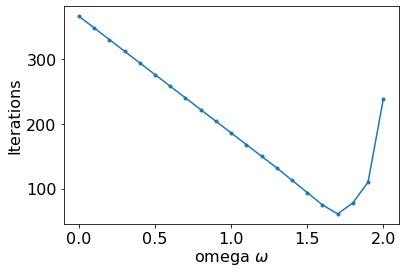

In [34]:
omegas = np.linspace(0,2,21)
its_sor = []
for omega in omegas:
    x, it = stationary_method(A, b, GaussSeidelPreconditioner(A, omega=omega))
    its_sor.append(it)
    
print("For omegas:", omegas)
print("Required SOR iterations:", its_sor)
plt.plot(omegas, its_sor, '.-')
plt.xlabel('omega $\omega$')
plt.ylabel('Iterations');

Above we see that for the finite-difference Poisson system there is a sweet spot at $\omega\approx 1.7$ where we only need $\approx 60$ iterations.

<div class="optional">
The Gauss Seidel method has the disadvantage that it depends heavily on the ordering of the degrees of freedom. As a trivial example let us look at an advection problem in 1D in a domain $0\leq x \leq L$:

$$
  \newcommand\dd[2]{\frac{\mathrm{d} #1}{\mathrm{d}#2}}
  \dd ct + u\dd cx = 0
$$

Let us assume that $u \gt 0$ (advection from left to right) and we have a boundary condition $c=1$ at $x=0$. A first order upwind discretisation combined with backward Euler (implicit Euler) is given by

$$
  \frac{c^{m+1}_i - c^m_i}{\Delta t} + u_i \frac{c^{m+1}_i - c^{m+1}_{i-1}}{\Delta x} = 0,
$$

here superscripts $m$ and $m+1$ refer to the old and new time level resp., and subscripts $i$ and $i-1$ to the grid point $i$, and grid point $i-1$ to the left of it. In matrix form this discretisation looks like:

$$
  \begin{pmatrix}
    1 & 0 & 0 & 0 & \dots & 0 \\
    -\frac{u_1}{\Delta x} & \frac 1{\Delta t} + \frac{u_1}{\Delta x} & 0 & 0 & \dots & 0\\
    0 & -\frac{u_2}{\Delta x} & \frac 1{\Delta t} + \frac{u_2}{\Delta x} & 0 & \dots & 0\\
    0 & 0 & -\frac{u_3}{\Delta x} & \frac 1{\Delta t} + \frac{u_3}{\Delta x} & \dots & 0\\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \dots & -\frac{u_{n-1}}{\Delta x} & \frac 1{\Delta t} + \frac{u_{n-1}}{\Delta x}
  \end{pmatrix}
  \begin{pmatrix}
    c^{m+1}_0 \\ c^{m+1}_1 \\ c^{m+1}_2 \\ c^{m+1}_3 \\ \vdots \\ c^{m+1}_{n-1}
  \end{pmatrix}
  =
  \begin{pmatrix}
    1 \\ \tfrac 1{\Delta t} c^m_1 \\ \tfrac 1{\Delta t} c^m_2 \\ \tfrac 1{\Delta t} c^m_3 \\ \vdots \\ \tfrac 1{\Delta t} c^m_{n-1}
  \end{pmatrix}
$$

For this system we have $\mat A=\mat D + \mat L$ exactly since $\mat U=0$, and so the Gauss Seidel returns with the exact solution in just one iteration! This remarkable result is based on the fact that we're sweeping the equations in the same order that the information travels. If the advection is going from right to left instead however ($u \lt 0$), we get an upper triangular matrix $\mat A=\mat D + \mat U$ with $\mat L=0$ so that Gauss Seidel ($\mat M=\mat D+\mat L$) would reduce to Jacobi ($\mat M=\mat D$). In this case we expect the performance to be much slower.
</div>

The example above, one dimensional advection, shows that the performance of Gauss Seidel
is much better if the advection is in the same direction as the ordering of the degrees of freedom. If the advection is in the opposite direction, we can use $\mat M=\mat D+\mat U$ instead. This method is called <a class="definition" href="#definitions" id="backwardGaussSeidel">backward Gauss Seidel</a>, and can be implemented as efficiently as <a class="definition" href="#definitions" id="forwardGaussSeidel">forward Gauss Seidel</a> ($\mat M=\mat D+\mat L$), by simply sweeping the equations backward.

In more general situations, we don't always know in advance which ordering is preferable - for instance, when including a diffusion term, information travels in both directions as the solution is dependent on the boundary conditions on both sides. A more generally robust method is therefore a symmetric variant of Gauss Seidel, which involves a sweep in both directions. In combination with the $\omega$-overrelaxation this method is called <a class="definition" href="#definitions" id="SymmetricSuccessiveOverRelaxationSSOR">Symmetric Successive Over-Relaxation (SSOR)</a> and is given by:

$$
  \mat M = \frac 1{\omega(2-\omega)} \left[\mat D + \omega\mat L\right]\mat D^{-1}\left[\mat D + \omega\mat U\right]
$$

This method is particularly effective for symmetric systems, as the approximate matrix $\mat M$ preserves this symmetry:

$$
  \mat A=\mat A^T \implies \mat U = \mat L^T \implies \mat M=\mat M^T
$$

The SSOR method is in fact convergent for any SPD matrix if $0 \lt \omega \lt 2$. Of course SSOR will generally be twice as expensive *per iteration* than forward or backward SOR, as it needs to do two sweeps instead of one.

In [35]:
class SSORPreconditioner(Preconditioner):
    """SSOR method"""
    def __init__(self, A, omega=1.0):
        super().__init__(A)
        self.DOL = sp.tril(A)  # DOL = D + L
        self.DOU = sp.triu(A)  # DOU = D + U
        if not omega==1.0:
            # add (omega-1)*L and (omega-1)*U resp.
            # see comments in GaussSeidelPreconditioner
            self.DOL += (omega-1.0)*sp.tril(A, -1)
            self.DOU += (omega-1.0)*sp.triu(A, 1)
            
        # every iteration we need to compute M^-1 r
        # from the definition of M above we get
        #   M^-1 = omega*(2-omega) * DOU^-1 * D * DOL^-1
        # (note the order is swapped)
        
        # we combine the steps of multiplying with the diagonal matrix M
        # and multiplying with the scalar omega*(2-omega) by scaling the diagonal:
        self.diag = A.diagonal()*(omega*(2-omega))    
        
    def __call__(self, r):
        # 1) do a lower triangular solve with DOL
        # 2) multiply with self.diag = diagonal(A)*omega*(2-omega)
        # 3) do a upper triangulaer solve with DOU using spsolve_triangular(..., lower=False)
        return spl.spsolve_triangular(self.DOU, self.diag * spl.spsolve_triangular(self.DOL, r), lower=False)


x, its_gs = stationary_method(A, b, SSORPreconditioner(A, omega=1.7))
print("SSOR: {} iterations".format(its_gs))

SSOR: 30 iterations


<div class="optional">
An advantage of the SSOR method is that it is generally less sensitive to the choice of $\omega$ for optimal performance.
</div>

For omegas: [0.5        0.57777778 0.65555556 0.73333333 0.81111111 0.88888889
 0.96666667 1.04444444 1.12222222 1.2        1.27777778 1.35555556
 1.43333333 1.51111111 1.58888889 1.66666667 1.74444444 1.82222222
 1.9       ]
Required SSOR iterations: [278, 229, 191, 161, 137, 118, 101, 87, 75, 65, 56, 49, 42, 37, 32, 30, 33, 48, 89]


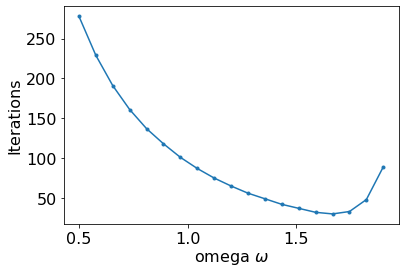

In [36]:

omegas = np.linspace(0.5,1.9,19)
its_ssor = []
for omega in omegas:
    x, it = stationary_method(A, b, SSORPreconditioner(A, omega=omega))
    its_ssor.append(it)
    
print("For omegas:", omegas)
print("Required SSOR iterations:", its_ssor)
plt.plot(omegas, its_ssor, '.-')
plt.xlabel('omega $\omega$')
plt.ylabel('Iterations');

## Incomplete LU (ILU) Decomposition
As we saw in the complexity analysis for LU decompositions, the amount of work required is directly related to the amount of fill-in (new nonzero entries) as we construct the decomposition. The idea behind the <a class="definition" href="#definitions" id="ILUmethod">ILU method</a> is to construct an approximate inverse by limiting the amount of fill-in that is allowed, that is we discard some of the new nonzero entries that appear in a full LU-decomposition.

<div class="optional">
The simplest form is to only allow nonzero entries in the same place as the original matrix $\mat A$. This is refered to as ILU(0). If we allow nonzero entries in the same as the matrix $\mat A^2$, which already has many more nonzero entries, the method is called ILU(1). Continuing this pattern, the ILU(k) method allows nonzero entries in the same place as the matrix $A^{k+1}$.

Other implementations of ILU, such as `spilu` in `scipy.sparse`, allow you to specify the amount of fill-in that is allowed as a factor (`fill_factor` below) of the initial number of nonzeros.</div>

In [37]:
class ILUPreconditioner(Preconditioner):
    """ILU preconditioner - wraps around spilu"""
    def __init__(self, A, fill_factor=1.0):
        super().__init__(A)
        self.Minv = spl.spilu(A.tocsc(), fill_factor=fill_factor) #, fill_factor=fill_factor, drop_tol=1e-4, options={'SymmetricMode': True})
        
    def __call__(self, r):
        return self.Minv.solve(r)
    
x, its_ilu0 = stationary_method(A, b, ILUPreconditioner(A))
x, its_ilu_ff2 = stationary_method(A, b, ILUPreconditioner(A, fill_factor=2.0))

print("ILU(0) method: {} iterations".format(its_ilu0))
print("ILU fill_factor=2: {} iterations".format(its_ilu_ff2))

ILU(0) method: 165 iterations
ILU fill_factor=2: 87 iterations


## Stationary Methods as Preconsditioner
A natural idea is to combine stationary methods:

$$
\vec x^{(k+1)} = \vec x^{(k)} + \mat P\vec r^{(k)}
$$

with the Steepest Descent method

$$
\vec x^{(k+1)} = \vec x^{(k)} + \alpha_k\vec r^{(k)},
$$

and consider an iteration of the form

\begin{align*}
\vec x^{(k+1)} &= \vec x^{(k)} + \alpha_k\mat P\vec r^{(k)} \\
    &= \vec x^{(k)} + \alpha_k\left(\mat P\vec b - \mat P~\mat A\vec x^{(k)}\right)
\end{align*}

On closer inspection, this is equivalent to applying the Steepest Descent method to the following modified linear system:

$$
  \mat P~\mat A \vec x = \mat P\vec b
$$

Of course, assuming $\mat P$ is invertible, this is equivalent to the linear system $\mat A\vec x=\vec b$.

Naturally we would also have to adjust our choice of $\alpha_k$. Remember that in the unmodified 
Steepest Descent method the optimal choice

$$
  \alpha_k = \frac{{\vec r^{(k)}}^T \vec r^{(k)}}{{\vec r^{(k)}}^T\mat A\vec r^{(k)}}
$$

was based on the associated quadratic function

$$
  f(\vec x) = \tfrac 12 \vec x^T\mat A\vec x - \vec b^T\vec x,
$$

and the idea that the new point $\vec x^{(k)}+\alpha^{(k)} \vec r^{(k)}$ should be chosen in the minimum of $f$ which means that $f'(\vec x^{(k+1)})=-\vec r^{(k+1)}$ should be orthogonal to $\vec r^{(k)}$.

In the modified method, we will continue to use $\vec r^{(k)}=\vec b - \mat A\vec x^{(k)}$, the residual with respect to the original system $\mat A\vec x=\vec b$, and use

$$
  \vec z^{(k)} = \mat P\vec r^{(k)} = \mat P\vec b - \mat P~\mat A \vec x^{(k)}
$$

for the residual with respect to the modified system. It is important to keep in mind that the association with the minimisation of a quadratic function relies on the assumption that matrix $\mat A$ is SPD and that in general the matrix $\mat P~\mat A$ is not. Therefore we use the same function $f$ (based on $\mat A$ not on $\mat P\mat A$) to find the minimum along the search direction. The negative gradient of $f$ is, as before, given by the residual $\vec r ^{(k)}$. For the search direction itself however, we do use $\vec z^{(k)}$.

<div class="optional">
To find the minimum along the search direction $\vec z^{(k)}$, as before, we require the gradient of $f$ in the new point, which is given by $\vec r^{(k+1)}$, to be orthogonal to the search direction:

$$
  \vec r^{(k+1)} = \vec b - \mat A\left(\vec x^{(k)} + \alpha^{(k)} \vec z^{(k)}\right) = \vec r^{(k)} - \alpha^{(k)} \mat A\vec z^{(k)},
$$

and thus

$$
  {\vec z^{(k)}}^T \vec r^{(k+1)} = 0 \implies \alpha_k = \frac{{\vec z^{(k)}}^T \vec r^{(k)}}{{\vec z^{(k)}}^T\mat A\vec z^{(k)}}.
$$
</div>

This leads to the following <a class="definition" href="#definitions" id="preconditionedsteepestdescent">preconditioned steepest descent</a> method:

In [38]:
def preconditioned_steepest_descent(A, b, P, rtol=1e-5):
    """Simple Steepest Descent method with zero initial guess and relative tolerance"""
    x = np.zeros_like(b)  # start with zero initial guess
    r = b - A @ x
    z = P(r)
    r0 = sl.norm(r)  # norm of initial residual
    it = 0
    while sl.norm(r)>rtol*r0:
        Az = A @ z
        alpha_star = np.dot(z, r)/np.dot(z, Az)
        x = x + alpha_star*z
        r = r - alpha_star*Az
        z = P(r)
        it += 1
    
    return x, it

nx = 10
A, b = A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
#A, b = Poisson_2D_Dirichlet_FE(tri['vertices'], tri['triangles'], tri['vertex_markers'], DBC=DBC_simple)


print("Number of iterations with various methods:")
x, its = steepest_descent(A,b)
print("Steepest descent:", its)
x, its = stationary_method(A,b, ILUPreconditioner(A))
print("ILU stationary method:", its)
x, its = preconditioned_steepest_descent(A,b, ILUPreconditioner(A))
print("ILU-preconditioned Steepest Descent:", its)
x, its = stationary_method(A,b, SSORPreconditioner(A, omega=1.7))
print("SSOR stationary method:", its)
x, its = preconditioned_steepest_descent(A,b, SSORPreconditioner(A, omega=1.7))
print("SSOR-preconditioned steepest descent", its)

Number of iterations with various methods:
Steepest descent: 375
ILU stationary method: 165
ILU-preconditioned Steepest Descent: 43
SSOR stationary method: 30
SSOR-preconditioned steepest descent 17


<div class="optional">
An alternative derivation of the same method can be made if, in addition to $\mat A$, also $\mat P$ is SPD (and therefore $\mat M=\mat P^{-1}$ is SPD). If we write $\mat M=\mat L\mat L^T$ for the Cholesky decomposition of $\mat M$ and start from the linear system

$$
  \mat L^{-1}\mat A\mat L^{-T} \vec y = \mat L^{-1}\vec b
  \text{ with } \vec y =\mat L^T\vec x
$$

then we can show that the standard Steepest Descent method based on the SPD matrix $\mat L^{-1}\mat A\mat L^{-T}$ is equivalent to the method above.</div>
    
The alternative derivation above shows that if $\mat M$ is SPD, the standard convergence proofs for Steepest Descent, which only apply for SPD matrices $\mat A$, also apply to preconditioned Steepest Descent if both $\mat A$ and $\mat M$ are SPD. It is therefore important that our approximation matrix $\mat M$ is SPD as well!

At first it might look surprising that the preconditioned method, is so much more effective than the original method. After all both iterations, can be written as unpreconditioned steepest descent, on its own a very simple method, just applied to different matrices. The explanation for this can be found in the fact that, as we have seen, the convergence of steepest descent is dependent on the condition number. As it turns out the transformation of the matrix $\mat A$ using an approximate inverse $\mat M$ greatly improves this condition number. Hence this transformation is typically referred to as <a class="definition" href="#definitions" id="preconditioning">preconditioning</a> and the approximate inverse itself a <a class="definition" href="#definitions" id="preconditioner">preconditioner</a>.

The exact same technique can also be applied to the Conjugate Gradient method.

In [39]:
nx = 10
A, b = A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)

counter = SimpleCounter()
x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter)
print("Iterations with unpreconditioned Conjugate Gradient:", counter.count)

counter = SimpleCounter()
x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter, M=SSORPreconditioner(A, omega=1.7))
print("Iterations with SSOR-preconditioned Conjugate Gradient:", counter.count)

Iterations with unpreconditioned Conjugate Gradient: 29
Iterations with SSOR-preconditioned Conjugate Gradient: 10


For linear systems based on an SPD matrix, the preconditioned Conjugate Gradient method is usually the method of choice. It is robust (in the sense that it is guaranteed to converge), relatively simple, and usually converges very fast in particular when combined with preconditioning techniques appropriate for the problem at hand. Again, care must be taken that the preconditioner is SPD. For instance the ILU algorithm in `spilu`, which we have used in the `ILUPreconditioner` does not generally guarantee this. <a class="definition" href="#definitions" id="IncompleteCholeskyfactorization">Incomplete Cholesky factorization</a>, is a preconditioner that is SPD, and is similar to ILU but now based on the Cholesky Decomposition $\mat A=\mat L^T\mat L$, instead of an $\mat A=\mat L\mat U$-decomposition.

In section 3 we will discuss some iterative methods for *non-SPD* linear systems, which are, like Conjugate Gradient and Steepest Descent, Krylov Subspace methods.

## Multigrid as Preconditioner: Algebraic Multigrid
In the previous sections we have seen that in a lot of problems based on the discretisation of PDEs, a large condition number (bad conditioning) is caused by the fact that the linear system permits both solutions that rapidly vary on the smallest (grid) scale, i.e. they are noisy solutions, and solutions that are smooth and only vary on the large scales. As it turns out the preconditioners we have discussed so far are good at reducing the part of the residual that consists of small scale noise, but have not much effect on the smooth part. This means that after applying the preconditioner a few times, the remaining residual is a lot smoother. For this reason the simple preconditioner we have discussed so far are also referred to as <a class="definition" href="#definitions" id="smoothers">smoothers</a>.

In [40]:
t_cg_sor = []
its_cg_sor = []
n = []
for nx in 40, 80: #160, 320, 640:   expand this to reproduce the timings plotted in the next cell
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    ssor = SSORPreconditioner(A, omega=1.7)
    time1 = timer()
    counter = SimpleCounter()
    x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter, M=ssor)
    time3 = timer()
    t_cg_sor.append(time3-time2)
    its_cg_sor.append(counter.count)
    n.append(A.shape[0])
    
print("Degrees Of Freedom:", n)
print("Timings Conjugate Gradient with SSOR:", t_cg_sor)
print("Iterations Conjugate Gradient with SSOR:", its_cg_sor)

Degrees Of Freedom: [1600, 6400]
Timings Conjugate Gradient with SSOR: [13.854771194048226, 18.33229612908326]
Iterations Conjugate Gradient with SSOR: [17, 26]


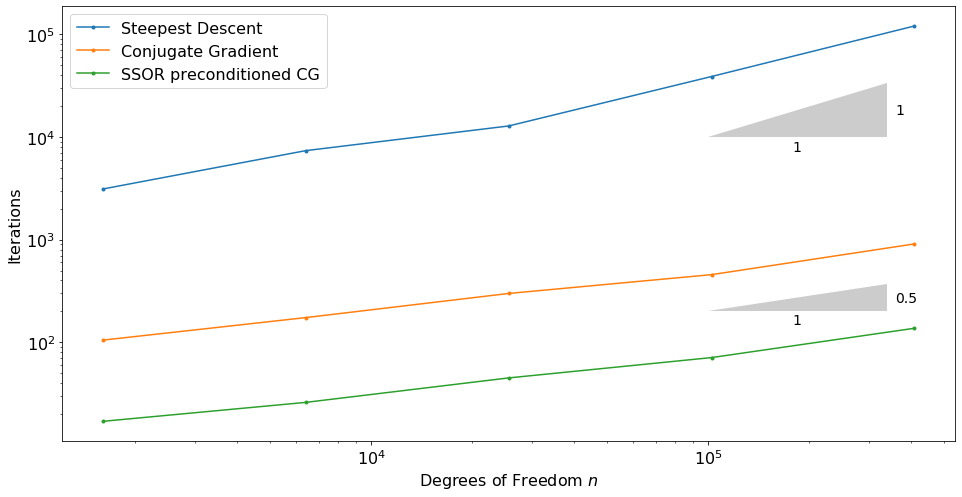

In [41]:
# these results were obtained earlier
n = [1600, 6400, 25600, 102400, 409600]

its_sd = [3111, 7354, 12785, 38758, 120365]
its_cg = [105, 174, 299, 456, 908]
its_cg_sor = [17, 26, 45, 71, 137]

fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.loglog(n, its_sd, '.-', label='Steepest Descent')
ax.loglog(n, its_cg, '.-', label='Conjugate Gradient')
ax.loglog(n, its_cg_sor, '.-', label='SSOR preconditioned CG')
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Iterations')
annotation.slope_marker((1e5, 200), (0.5, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e5, 1e4), (1, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.legend();

The figure above shows, that although the combination of Conjugate Gradient with SSOR as a preconditioner has significantly reduced the number of iterations (green) compared with unpreconditioned CG (orange), the scaling is still the same: the number of iterations is roughly proportional to the square root of the problem size $n$. The reason for this is that SSOR acts like a smoother which efficiently deals with the residual at the grid scale, but since with increasing resolution we keep on adding new scale, the condition number of the preconditioned system still deteriorates. (Note that we don't compare timings here, because the implementation of SSOR in this notebook is very slow - this would not be the case for a decent implementation of SSOR in a solver library).

Multigrid methods are designed to also effectively handle the large scale component of the residual. After applying a smoother (simple preconditioner), to remove the noisy parts from the residual, our approximate solution is projected onto a coarser grid and a residual on the coarser grid is computed. If we then apply a smoother but now on the coarse-grid residual, because the grid-scale at which the smoother is effective is now at a larger scale, it will now also filter out some larger scale components of the residual. This process may be repeated a few times, projecting onto ever coarser grids until we arrive at a grid that is so coarse there is not much difference anymore between the large scale and the grid scale, so that we can efficiently solve for even the largest scales of the problem.

<div>
<img src="figures/amg.svg"/>
<a href="http://user.it.uu.se/~maya/Projects/3phase/AMG_parallel_Falgout.pdf">source</a></div>

The coarse grid solution we have obtained is only a very coarse approximation of the solution on the original much finer mesh. Thus as we go back projecting the coarse solution back onto finer meshes, we again introduce errors, but these can be effectively handled by smoother at those levels. We thus get a hierarchy of the finest (original) grid with a number of levels of coarsers grids below, and we may have to traverse this hierarchy up and down a few times to sufficiently reduce the error at all scales.

<div>
<img src="https://www.researchgate.net/profile/Francesc_Verdugo/publication/301896254/figure/fig1/AS:359114438922242@1462630962479/Illustration-of-a-multigrid-V-cycle-with-3-levels.png"/>
source: <a href="https://arxiv.org/abs/1605.01522">DOI: 10.1016/j.cma.2016.07.016</a></div>

There are two main approaches:

* In <a class="definition" href="#definitions" id="GeometricMultigrid">Geometric Multigrid</a> the problem is rediscretized at the coarser levels to compute coarser grid residuals. This typically requires integration with the actual discretisation code, meaning that it does not provide a standalone solver of the original linear system at the highest resolution.

* <a class="definition" href="#definitions" id="AlgebraicMultigridAMG">Algebraic Multigrid (AMG)</a> methods only use the information available from the linear system at the finest (original) resolution. It uses the algebraic properties of the matrix to construct a hierarchy of coarser linear problems. Since this solution method does not have direct access to the discretisation method used to assemble the original linear system, geometric multigrid methods can be more effective on some types of problems. There are many problems where AMG works very well however, e.g. finite element discretisations of elliptic problems like Poisson's equation. In particular AMG can be an effective method in problems where anisotropy plays a role.

Algebraic multigrid is also often used as a preconditioner, where a single cycle of traversing the multigrid hierarchy is applied in every iteration of the iterative solver it is combined with. Here we'll repeat the timings of solving the Poisson problem on a series of grids of increasing size but now applying an Algebraic Multigrid preconditioner. For this we use the pyamg package, which again you can install with `pip install pyamg`.

In [42]:
import pyamg
class AMGPreconditioner(Preconditioner):
    """AMG preconditioner - wraps around pyamg's ruge_stuben_solver"""
    def __init__(self, A):
        super().__init__(A)
        ml = pyamg.ruge_stuben_solver(A.tocsr(), strength=('classical'))
        self.gamg = ml.aspreconditioner()
        
    def __call__(self, r):
        return self.gamg(r)
    

amg = AMGPreconditioner(A)   
x, its_amg = stationary_method(A, b, amg)

print("AMG method: {} iterations".format(its_amg))

AMG method: 8 iterations


That's very promising indeed: applied as a stationary method AMG only requires 8 iterations. That is, on a small system with $N_x=10$, i.e. $n=100$ degrees of freedom. Let's see how it fares for larger problems. We repeat the same sequence as at the end of section 2, where we saw the condition number, and thus the number of iterations, increasing with the size of the problem for both steepest descent and conjugate gradient. This badly affected the overall complexity of the algorithms.

In [43]:
t_sd_amg = []
t_cg_amg = []
t_sm_amg = []
its_sd_amg = []
its_cg_amg = []
its_sm_amg = [] 
n = []
for nx in 40, 80, 160, 320, 640:
    A, b = Poisson_2D_Dirichlet_FD(nx, nx, RHS_f, DBC)
    amg = AMGPreconditioner(A)
    time1 = timer()
    x, it_sd_amg = preconditioned_steepest_descent(A, b, amg)
    time2 = timer()
    counter = SimpleCounter()
    x, info_cg = spl.cg(A,b, tol=1e-5, callback=counter, M=amg)
    time3 = timer()
    x, it_sm_amg = stationary_method(A, b, amg)
    time4 = timer()
    t_sd_amg.append(time2-time1)
    t_cg_amg.append(time3-time2)
    t_sm_amg.append(time4-time3)
    its_sd_amg.append(it_sd_amg)
    its_cg_amg.append(counter.count)
    its_sm_amg.append(it_sm_amg)
    n.append(A.shape[0])
    
print("Degrees Of Freedom:", n)
print("Timings stationary AMG method:", t_sm_amg)
print("Timings Steepest Descent with AMG:", t_sd_amg)
print("Timings Conjugate Gradient with AMG:", t_cg_amg)
print("Iterations stationary AMG method", its_sm_amg)
print("Iterations Steepest Descent with AMG", its_sd_amg)
print("Iterations Conjugate Gradient with AMG:", its_cg_amg)

Degrees Of Freedom: [1600, 6400, 25600, 102400, 409600]
Timings stationary AMG method: [0.0051599330035969615, 0.010125485016033053, 0.039999440079554915, 0.18077317299321294, 0.6187497390201315]
Timings Steepest Descent with AMG: [0.006212746957316995, 0.010330307995900512, 0.03608429594896734, 0.17585432308260351, 0.7441661619814113]
Timings Conjugate Gradient with AMG: [0.0044449870474636555, 0.007944263983517885, 0.028269601985812187, 0.14884458493907005, 0.6416255279909819]
Iterations stationary AMG method [7, 8, 7, 7, 6]
Iterations Steepest Descent with AMG [6, 7, 6, 7, 7]
Iterations Conjugate Gradient with AMG: [5, 6, 5, 6, 6]


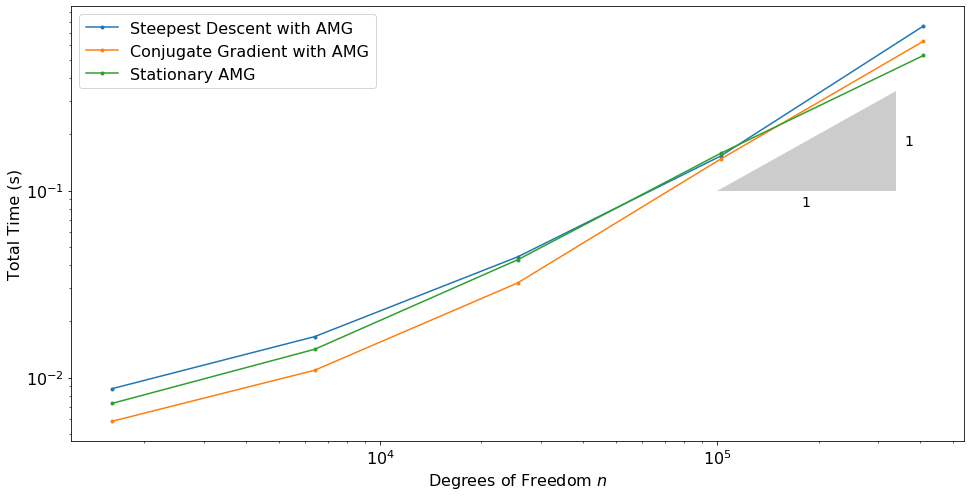

In [44]:
# these results were obtained earlier
n = [1600, 6400, 25600, 102400, 409600]
t_sd_amg = [0.008715360891073942, 0.016562061849981546, 0.04418520303443074, 0.15286784199997783, 0.7586283159907907]
t_cg_amg = [0.005834514973685145, 0.010947155067697167, 0.03205305407755077, 0.14723233692348003, 0.6288821210619062]
t_sm_amg = [0.00727049820125103, 0.014169652946293354, 0.042649316834285855, 0.15807449421845376, 0.5276029279921204]

fig, ax = plt.subplots(1,1,figsize=(16,8))
fig.subplots_adjust(hspace=0.3)
ax.loglog(n, t_sd_amg, '.-', label='Steepest Descent with AMG')
ax.loglog(n, t_cg_amg, '.-', label='Conjugate Gradient with AMG')
ax.loglog(n, t_sm_amg, '.-', label='Stationary AMG')
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Total Time (s)')
annotation.slope_marker((1e5, 1e-1), (1, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

ax.legend();

Now we see something remarkable: the number of required iterations does not increase with problem size at all! This means that the overall complexity is the same as the complexity of a single iteration, which for sparse matrices means the algorithm is $O(n)$, i.e. the overall cost scales linearly with problem size. Viewed as a preconditioner one can say that AMG, by being effective at all scales simultaneously, manages to keep the condition number constant.

To appreciate the progress we have made, let's also plot this together with the unpreconditioned results at the end of section 2:

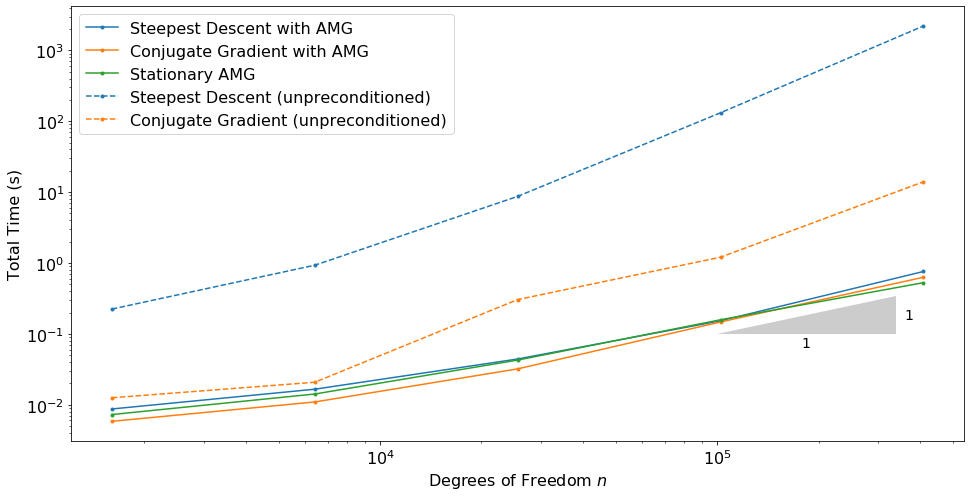

In [45]:
n = [1600, 6400, 25600, 102400, 409600]

# unpreconditioned results at the end of section 2:
t_sd = [0.22358962999715004, 0.929597759997705, 8.69946387001255, 131.54660375899402, 2206.4073799010075]
t_cg = [0.012539653005660512, 0.020767997004440986, 0.3044052179902792, 1.206662315002177, 13.987541098991642]

# with amg:
t_sd_amg = [0.008715360891073942, 0.016562061849981546, 0.04418520303443074, 0.15286784199997783, 0.7586283159907907]
t_cg_amg = [0.005834514973685145, 0.010947155067697167, 0.03205305407755077, 0.14723233692348003, 0.6288821210619062]
t_sm_amg = [0.00727049820125103, 0.014169652946293354, 0.042649316834285855, 0.15807449421845376, 0.5276029279921204]

fig, ax = plt.subplots(1,1,figsize=(16,8))
fig.subplots_adjust(hspace=0.3)
l_sd, = ax.loglog(n, t_sd_amg, '.-', label='Steepest Descent with AMG')
l_cg, = ax.loglog(n, t_cg_amg, '.-', label='Conjugate Gradient with AMG')
l_sm, = ax.loglog(n, t_sm_amg, '.-', label='Stationary AMG')
ax.loglog(n, t_sd, '.--', color=l_sd.get_color(), label='Steepest Descent (unpreconditioned)')
ax.loglog(n, t_cg, '.--', color=l_cg.get_color(), label='Conjugate Gradient (unpreconditioned)')
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Total Time (s)')
annotation.slope_marker((1e5, 1e-1), (1, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

ax.legend();

# Krylov Subspace Methods

## Steepest Descent method as Krylov Subspace Method

For the Steepest Descent method

$$
  \vec x^{(i+1)} = \vec x^{(i)} + \alpha^{(i)}\vec r^{(i)}
$$

with residual vectors

$$
  \vec r^{(i)} = \vec b - \mat A\vec x^{(i)}
$$

and coefficients

$$
  \alpha^{(i)} = \frac{{\vec r^{(i)}}^T \vec r^{(i)}}{{\vec r^{(i)}}^T \mat A\vec r^{(i)}}
$$

we can derive the following update equation that computes the new residual vector from the previous residual vector:

\begin{align*}
  \vec r^{(i+1)} &= \vec b - \mat A\vec x^{(i+1)} \\
  &= \vec b - \mat A \left( \vec x^{(i)} + \alpha^{(i)}\vec r^{(i)} \right) \\
  &= \vec b - \mat A \vec x^{(i)} - \alpha^{(i)} \mat A \vec r^{(i)} \\
    &= \vec r^{(i)} - \alpha^{(i)} \mat A \vec r^{(i)}
\end{align*}

Using this, we can work out the residual in every iteration and relate it to the initial residual $\vec r^{(0)}$:

\begin{align*}
   \vec r^{(1)} &= \vec r^{(0)} - \alpha^{(0)} \mat A \vec r^{(0)} \\
   \vec r^{(2)} &= \vec r^{(1)} - \alpha^{(1)} \mat A \vec r^{(1)} \\
   &= \vec r^{(0)} - \alpha^{(0)} \mat A \vec r^{(0)} - \alpha^{(1)} \mat A \left(
   \vec r^{(0)} - \alpha^{(0)} \mat A \vec r^{(0)}\right) \\
   &= \vec r^{(0)} - \left(\alpha^{(0)}+\alpha^{(1)}\right) \mat A\vec r^{(0)}
   + \alpha^{(0)}\alpha^{(1)} \mat A^2 \vec r^{(0)} \\
   \vec r^{(3)} &= \vec r^{(2)} - \alpha^{(2)} \mat A \vec r^{(2)} \\
   &=\dots \\
   &= \vec r^{(0)} - \left(\alpha^{(0)}+\alpha^{(1)}+\alpha^{(2)}\right) \mat A\vec r^{(0)} + \left(\alpha^{(0)}\alpha^{(1)}+\alpha^{(2)}\alpha^{(0)}+\alpha^{(2)}\alpha^{(1)}\right) \mat A^2\vec r^{(0)}
   \\
   &\phantom{=\vec r^{(0)}}- \alpha^{(0)}\alpha^{(1)}\alpha^{(2)}\mat A^3\vec r^{(0)} \\
   r^{(4)} &= \dots
\end{align*}

Continuing this pattern, we see that every residual vector $\vec r^{(k)}$ can be written as a linear combination of the vectors

$$
  \vec r^{(0)}, \mat A\vec r^{(0)}, \mat A^2\vec r^{(0)}, \dots
  \mat A^k\vec r^{(0)}
$$

In other words, if we define the vector subspaces spanned by these vectors as:

\begin{align*}
  \mathcal{D}_0 &=
\operatorname{span}\{\vec r^{(0)}\}, \\
  \mathcal{D}_1 &=
\operatorname{span}\{\vec r^{(0)}, \mat A\vec r^{(0)}\} \\
  \mathcal{D}_2 &=
\operatorname{span}\{\vec r^{(0)}, \mat A\vec r^{(0)}, \mat A^2\vec r^{(0)}\} \\
\cdots \\
  \mathcal{D}_n &= \operatorname{span}\{\vec r^{(0)}, \mat A\vec
r^{(0)}, \cdots
    \mat A^n\vec r^{(0)}\}
\end{align*}

then we know that

$$
  \vec r^{(k)} \in \mathcal{D}_k
$$

Moreover, if $i\lt k$ then $\mathcal{D}_i \subset \mathcal{D}_k$, and therefore

$$
  \vec r^{(i)} \in \mathcal{D}_k\quad \text{for all } i\leq k
$$

The vector space $\mathcal{D}_k$ is called the <a class="definition" href="#definitions" id="Krylovsubspace">Krylov subspace</a>.

We can also work out that the $k$-th position is given by:

\begin{align*}
  \vec x^{(k)} &= \vec x^{(k-1)} + \alpha^{(k-1)} \vec r^{(k-1)} \\
  &= \vec x^{(k-2)} + \alpha^{(k-2)} \vec r^{(k-2)} + \alpha^{(k-1)} \vec r^{(k-1)} \\
  &= \dots \\
  &= \vec x^{(0)} + \alpha^{(0)}\vec r^{(0)} + \dots \alpha^{(k-1)} \vec r^{(k-1)} \\
  \text{or}\quad \vec x^{(k)} - \vec x^{(0)} &= \sum_{i=0}^{k-1}
  \alpha^{(i)} \vec r^{(i)}
\end{align*}

Since all the residual vector on the right-hand side are in $\mathcal{D}_{k-1}$, we know that

$$
  \vec x^{(k)} - \vec x^{(0)} \in \mathcal{D}_{k-1}
$$

It turns out that there are many iterative algorithms for which this holds: the step from the inital guess $\vec x^{(0)}$ to the $k$-th position $\vec x^{(k)}$ is found in the Krylov subspace $\mathcal{D}_{k-1}$. Such algorithms are called <a class="definition" href="#definitions" id="Krylovsubspacemethods">Krylov subspace methods</a>. Note that the definition of the Krylov subspace does not depend on any particular choice we made for Steepest Descent - all Krylov subspace methods find their $k$-th position in the same subspace!

## Conjugate Gradient as Optimal Krylov Subspace Method

Let's remind ourselves of the Conjugate Gradient algorithm of lecture 2:

\begin{align*}
   \vec p^{(0)} =
\vec r^{(0)} = \vec b - \mat A\vec x^{(0)} \\
\text{for } i\in\{0, 1, \cdots,
n-1\}: \\
   \alpha^{(i)} &= \frac{\vec
r^{(i)}\cdot\vec r^{(i)}}{\vec
p^{(i)}\cdot\mat A\vec p^{(i)}} \\
   \vec
x^{(i+1)} &= \vec x^{(i)} +
\alpha^{(i)} \vec p^{(i)} \\
   \vec r^{(i+1)} &=
\vec r^{(i)} - \alpha^{(i)}
\mat A\vec p^{(i)} \\
   \beta^{(i+1)} &= \frac{\vec
r^{(i+1)}\cdot\vec
r^{(i+1)}}{\vec r^{(i)}\cdot\vec r^{(i)}} \\
   \vec
p^{(i+1)} &= \vec r^{(i+1)}
+ \beta^{(i+1)}\vec p^{(i)}
\end{align*}

Every new iterate $\vec x^{(k+1)}$ is formed from a linear combination
of step vectors $\vec p^{(i)}$

$$
  \vec x^{(k+1)} = \vec x_{(0)} + \sum_{i=0}^k \alpha^{(i)}\vec p^{(i)}
$$

The step vector themselves are a linear combination of residual vectors $\vec r^{(i)}$.

In the same way as for Steepest Descent we can derive

\begin{align*}
  \vec x^{(k+1)}-\vec x^{(0)} \in \mathcal{D_k} \\
  \vec r^{(i)} \in \mathcal{D_k} \quad\text{for all } i\leq k \\
  \vec p^{(i)} \in \mathcal{D_k} \quad\text{for all } i\leq k \\
\end{align*}

### Minimum in the Krylov Subspace <a class="tocSkip"></a>
In other words, the Conjugate Gradient algorithm is a Krylov subspace method, which like any other such method, chooses $\vec x^{(k+1)}$ to be in the space $\vec x^{(0)}+ \mathcal{D_k}$

As we know, every new point $\vec x^{(k+1)}$ is chosen in a minimum of $f$ along the line $\vec x^{(k)}+\alpha\vec p^{(k)}$, where $f$ is the quadratic function

$$
f(\vec x) = \tfrac 12\vec
x^T\mat A\vec x - \vec
b^T\vec x
$$

whose gradient $f'(\vec x)=\mat A\vec x - \vec b$ equals the negative of the residual vector $\vec r=\vec b - \mat A\vec x$. Its minimum (unique because of $\mat A$ being SPD) in $x^*$ coincides with the solution to $\mat A\vec x^*=\vec b$. Because we choose $\vec x^{(k+1)}$ in a minimum along the line spanned by $\vec p^{(k)}$, the gradient in the new point, and thus the new residual, must be orthogonal to $\vec p^{(k)}$

$$
  \vec p^{(k)}\cdot\vec
r^{(k+1)} = 0
$$

As we have shown in lecture 2 however, the new residual is not only orthogonal to the last search direction, but to all previous search directions as well. This means that $\vec r^{(k+1)}$ is orthogonal to all vectors in $\mathcal{D}_k$. In particular this means that in $\vec x^{(k+1)}$, $\vec f$ does not vary in any direction that lies within the Krylov subspace:

$$
  \left.\frac d{dt}\right|_{t=0} f(\vec x^{(k+1)} +t\vec v) = 0, \text{ for all } \vec v\in\mathcal{D}_k
$$

In conclusion, this means that $\vec x^{(k+1)}$ is not just the minimum along the search direction but the minimum of $f$ anywhere in $\vec x_0 + \mathcal{D}_k$. Thus we can summarize the Conjugate Gradient method as the unique method that chooses $\vec x^{(k+1)}$ in the minimum of $f$ in the subspace $\vec x_0 + \mathcal{D}_k$.

### Minimum error in the A-norm <a class="tocSkip"></a>
An alternative, equivalent, formulation is based on the fact that the error between the new point $\vec x^{(k+1)}$ and the exact solution $\vec x^*$, can be related to the residual via:

$$
  \vec r^{(k+1)} = \vec b - \mat A\vec x^{(k+1)} = \mat A \left(\vec x^* - \vec x^{(k+1)}\right)
$$

Therefore

$$
  {\vec r^{(k+1)}}^T \vec v = 0, \text{ for all } \vec v\in\mathcal{D}_k \iff
  \left(\vec x^* - \vec x^{(k+1)}\right)^T \mat A \vec v = 0, \text{ for all } \vec v\in\mathcal{D}_k
$$

that is to say $\vec x^*-\vec x^{(k+1)}$ is $\mat A$-orthogonal to all vectors in $\mathcal{D}_k$, and thus the vector pointing from $\vec x^{(k+1)}$ to $\vec x^*$ is $\mat A$-orthogonal to the subspace $\vec x_0+\mathcal{D}_k$. In turn this can be shown to be equivalent to saying that $\vec x^{(k+1)}$ is chosen to be the *closest* point to $\vec x^*$ in $x_0+\mathcal{D}_k$ *measured in the $\mat A$-norm*.

<div class="optional">
This also follows from

\begin{align*}
  \| \vec x^* - \vec x^{(k+1)}\|_{\mat A}^2
  &=
  \left(\vec x^* - \vec x^{(k+1)}\right)^T \mat A \left(\vec x^* - \vec x^{(k+1)}\right) \\
  &=
  {\vec x^*}^T \mat A \vec x^* - {\vec x^*}^T \mat A \vec x^{(k+1)}
  - {\vec x^{(k+1)}}^T \mat A \vec x^* + {\vec x^{(k+1)}}^T \mat A \vec x^{(k+1)} \\
  &=
  {\vec x^*}^T \mat A \vec x^* - {\vec x^*}^T \mat A \vec x^{(k+1)}
  - {\vec x^{(k+1)}}^T \mat A \vec x^* + {\vec x^{(k+1)}}^T \mat A \vec x^{(k+1)} \\
  &=
  {\vec x^*}^T \vec b - \vec b^T  \vec x^{(k+1)}
  - {\vec x^{(k+1)}}^T \vec b + {\vec x^{(k+1)}}^T \mat A \vec x^{(k+1)}  \\
  &= 2 f(x^{(k+1)}) + {\vec x^*}^T \vec b
\end{align*}

which shows that the minimisation of $f$ on $x_0+\mathcal{D}_k$ is the same as the minimisation of $\| \vec x^* - \vec x^{(k+1)}\|_{\mat A}^2$.
</div>

In summary, the Conjugate Gradient method chooses the unique new point $\vec x^{(i+1)}$ in $\vec{x_0}+\mathcal{D}_i$ that minimizes the distance

$$
\| \vec x^* - \vec x^{(i+1)}\|_{\mat A}
$$

to $\vec x^*$ in the $\mat A$-norm.

## Generalized Minimum RESidual (GMRES) Method
A Krylov Subspace method is any iterative method, which chooses every iterate from the Krylov Subspace

$$
  \vec x^{(k+1)} \in \vec x^{(0)} + \mathcal{D}_k(\mat A),
$$

with the Krylov Subspace being expanded every iteration by a further application of the matrix $\mat A$. There are a number of these methods, the difference between them lies in how this choice is made. For SPD matrices we have seen that there is an optimal choice which also leads to a relatively simple algorithm, the Conjugate Gradient method. For matrices that do not fall in this category, things are not so straightforward.

In an ideal method, the optimal choice would be based on the minimisation of the actual error $\|\vec x^*-\vec x^{(k+1)}\|$, but without knowing $\vec x^*$ it is not clear how this could be achieved. For non-SPD matrices, $\|\cdot\|_{\mat A}$ is *not* a norm - in particular it may go negative, and thus $\|\vec x^*-\vec x^{(k+1)}\|_{\mat A}$ does not have a minimum at $\vec x^{(k+1)}=\vec x^*$. The best we can do is to propose a method based on the minimisation of the residual:

$$
  \text{GMRES: choose }\vec x^{(k+1)}\in \vec x^{(0)} + \mathcal{D}_k
  \text{ that minimizes }\|\vec b - \mat A\vec x^{(k+1)}\|
$$

This method is called the <a class="definition" href="#definitions" id="GeneralizedMinimumResidualGMRESmethod">Generalized Minimum Residual (GMRES) method</a>, so called because it was developed as a generalisation of the Minimum Residual (MINRES) method, a method for symmetric - but not necessarily positive definite - matrices.

### Implementation (*) <a class="tocSkip"></a>
<div class="optional">    
The first problem with deriving an efficient implementation for this method, is that in every iteration we would have to perform an optimisation - and, although the minimisation takes place in a much smaller $k+1$-dimensional subspace $\mathcal{D}_k$ of $\R^n$, we would still have to perform matrix-vector multiplications $\vec A\vec x$ in full $\R^n$ to evaluate the residual in different points of this subspace. This situation can be improved by choosing a orthonormal basis for $\mathcal{D}_k$: $\vec q_0, \vec q_1, \dots \vec q_k$ which is given by the following *Gramm-Schmidt* orthogonalisation:

$$
  \vec q_{j+1} = \frac{\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i}
  {\|\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\|},
  \text{ with }
  h_{ij} = \left(\mat A\vec q_j\right)^T\vec q_i = \vec q_i^T \mat A\vec q_j
  \label{Gramm-Schmidt} \tag{Gramm-Schmidt}
$$

with the first basis vector given by

$$
  \vec q_0 = \frac{\vec b-\mat A\vec x^{(0)}}{\|\vec b-\mat A\vec x^{(0)}\|}
$$

This is typically implemented by the Arnoldi iteration:
```python
    q[j+1] = A @ q[j]
    for i in range(j+1):
        h[i, j] = np.dot(q[j+1], q[i])
        q[j+1] -= h[i, j]*q[i]
    h[j+1, j] = sl.norm(q[j+1])
    q[j+1] = q[j+1]/h[j+1, j]
    
```
Although not immediately obvious, this modified Gramm-Schmidt orthogonalisation, produces the same result as $\eqref{Gramm-Schmidt}$ (assuming exact arithmetic). The reason the Arnoldi iteration is preferable is numerical stability: due to round-off errors the orthogonalisation following $\eqref{Gramm-Schmidt}$ may lead to build-up of errors that lead to the basis becoming not exactly orthogonal.

Note that the $h_{ij}$ coefficients in $\eqref{Gramm-Schmidt}$ are only defined for $0\leq i\leq j$, i.e. they form an upper triangular matrix. Furthermore we have

\begin{align*}
    \|\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\|^2
    &=
    \left(\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\right)^T
    \left(\mat A\vec q_j - \sum_{k=0}^j h_{kj} \vec q_k\right) \\
    &=
    \|\mat A\vec q_j\|^2 + \sum_{i=0}^j \sum_{k=0}^j h_{ij}h_{kj} \vec q_i\vec q_k
    -2 \sum_{i=0}^j h_{ij} \vec q_i^T\mat A\vec q_j \\
    &= \|\mat A\vec q_j\|^2 + \sum_{i=0}^j h_{ij}^2 -2 \sum_{i=0}^j h_{ij}^2
    = \|\mat A\vec q_j\|^2 - \sum_{i=0}^j h_{ij}^2
\end{align*}

and thus

\begin{align*}
  \vec q_{j+1}\mat A\vec q_j
  &=
  \frac{\left(\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\right)^T \mat A\vec q_j}
  {\|\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\|} \\
  &= \frac{\|\mat A\vec q_j\|^2 - \sum_{i=0}^j h_{ij} \vec q_i^T\mat A\vec q_j}
  {\sqrt{\|\mat A\vec q_j\|^2 - \sum_{i=0}^j h_{ij}^2}} \\
  &= \|\mat A\vec q_j - \sum_{i=0}^j h_{ij} \vec q_i\|
\end{align*}

which means that the Arnoldi iteration gives us the coefficient $h_{ij}=\vec q^T_i\mat A\vec q_j$ for all $0\leq i\leq j+1$. Finally, for $i \gt j+1$ we have that $\mat A\vec q_j$ is in $\mathcal{D}_{j+1}$ and since we choose $\vec q_i$ to be orthogonal to all $\vec q_k, 0\leq k\leq j+1$ that span $\mathcal{D}_{j+1}$, $\vec q_i$ must be orthogonal to $\mat A\vec q_j$. So by defining a matrix $h_{ij}=\vec q^T_i\mat A\vec q_j$ we have that $h_{ij}=0$ for $i \gt j+1$. A matrix of this form, which is upper triangular with one extra diagonal below the main diagonal, is called a *Hessenberg matrix*.

Using this orthonormal basis we can write the vector $\vec x^{k+1} - \vec x_0$ as a linear combination

$$
  \vec x^{(k+1)} - \vec x^{(0)} = \sum_{j=0}^k \vec y_j \vec q_j
$$

where $\vec y$ is a vector in $\R^{k+1}$ of the coefficients with respect to the orthonormal basis $\vec q_j$. The residual

$$
  \vec r^{(k+1)} = \vec b - \mat A\vec x^{(k+1)} = \vec b - \mat A\vec x^{(0)} - \mat A\left(\vec x^{(k+1)} - \vec x^{(0)}\right)
  = \vec r^{(0)} - \sum_{j=0}^{k} \vec y_j \mat A\vec q_j.
$$

This residual itself can also be written as a linear combination of the $\vec q_i$ but now in the enlarged Krylov subspace $\mathcal{D}_{k+1}$:

\begin{align*}
  \vec r^{(k+1)} &= \sum_{i=0}^{k+1} \left(\vec q^T_i \vec r^{(k+1)}\right) \vec q_i \\
  &= \sum_{i=0}^{k+1} \left(\vec q^T_i\vec r^{(0)} - \sum_{j=0}^{k} \vec y_j \vec q^T_i\mat A\vec q_j\right) \vec q_i \\
  &= \sum_{i=0}^{k+1}\left(\vec q^T_i\vec q_0 \|\vec r^{(0)}\| - \sum_{j=0}^k h_{ij}\vec y_j\right) \vec q_i,
\end{align*}

here we have reused the Hessenberg matrix $h_{ij}$ that is already calculated in the Arnoldi iteration.
Due to the orthogonality of the $\vec q_i$ the norm of the residual then reduces to the norm of a vector in $\R^{k+2}$

<a name="Least-Squares-GMRES"></a>
$$
 \| \vec r^{(k+1)} \| = \left\|
 \left(
   \| \vec r^{(0)}\|, 0, 0, \dots, 0
 \right)^T
 -
 \mat H\vec y \right\|
 \label{Least-Squares-GMRES}
 \tag{Least-Squares-GMRES}
$$

where $\mat H$ is the matrix with coefficients $h_{ij}$ that maps the vector $\vec y\in\R^{k+1}$ to a vector in $\R^{k+2}$. The last equation reveals that we have reduced the minimisation problem to an over-constrained linear least-squares problem with $k+1$ variables (the $\vec y$-vector) and $k+2$ constraints.
</div>

### Complexity of GMRES <a class="tocSkip"></a>
<div class="optional">
Iteration $k$ of the GMRES method can now be summarized as:
    
1. Calculate an orthogonal basis $\vec q_i$ for the Krylov subspace $\mathcal{D}_k$ (Arnoldi iteration)
2. By writing $\vec x^{(k+1)} - \vec x^{(0)}$ as a linear combination of the basis $\vec q_i$ with coefficients $y_i$ (see step 3), the minimisation of $\vec r^{(k+1)}$ becomes a least squares problem <a href="#Least-Squares-GMRES">(Least-Squares-GMRES)</a> for a vector $\vec y\in\R^{k+1}$.
3. Reconstruct $\vec x^{(k+1)} = \vec x^{(0)} + \sum_{i=0}^k \vec y_i \vec q_i$
4. Check the convergence criterion, and return to 1) unless it is satisfied

In iteration $k+1$, the inner products in step 1. have a complexity of $O(kn)$, since there are $k$ previous vectors to orthogonalize against. In addition we need to do one matrix-vector multiplication which, assuming the matrix is sparse is $O(n)$. A general approach to the least squares problem in step 2. would be $O(k^3)$. Terminating after $k$ iterations this would lead to an overall cost of $O(k^2n + k^4)$. There is a more efficient approach however that takes into account that we are solving the same expanding least-squares problem every iteration. In this approach we do not explicitly obtain $\vec y$ in every iteration, and neither therefore the solution vector $\vec x^{(k+1)}$. </div>If the iteration terminates in $k$ iterations we then have an overall $O(k^2n)$ cost to the algorithm.

Like the Conjugate Gradient method, GMRES is guaranteed to converge to the exact answer in at most $n$ iterations (\*). In most cases however, like with CG, the residual drops rapidly after only a relatively small number of iterations such that we can typically terminate early. Unlike CG however, there is no general guarantee for how fast GMRES converges. For asymmetric matrices, eigenvalues can be complex, and not all asymmetric matrices are diagonalizable (i.e. they don't have a complete basis of eigenvectors that spans $\R^n$). This means the converge behaviour is not just a matter of the ratio between the largest and smallest eigenvalue (condition number). 
<br/>
<br/>
<div class="optional">
(*) This is based on the fact that after $n$ iterations we have obtained $n$ independent vectors that form a basis for all of $\R^n$: the Krylov subspace covers all of $\R^n$.  In fact it can be shown, that if in some iteration the dimension of the Krylov subspace is not increased because the new residual is not linearly independent of the previous Krylov subspace vectors, the residual can be reduced to exactly zero. So either GMRES terminates early (before $n$ iterations) with the exact answer, or the dimension of the Krylov subspace is increased every iteration and reaches all $n$ dimensions after $n$ iterations.
<br/>
<br/>
A general rule for GMRES is that good convergence can be obtained if the eigenvalues are clustered away from the origin in the complex plane, i.e. they are close together but do not surround the origin. In addition better convergence is obtained with <a class="definition" href="#definitions" id="normalmatrices">normal matrices</a>, matrices for which $\mat A^*\mat  A = \mat  A\mat A^*$, or matrices that are "close to normal".
</div>

### Restarted GMRES <a class="tocSkip"></a>
Although the direct scaling of the cost of GMRES with $n$ is only linear, there is of course an indirect contribution of the number of iterations, $k$, which as we have seen often also increases with $n$. In addition GMRES has signficant storage costs, $O(kn)$, which may become a problem if the number of iterations is large. For this reason a compromise can be found where the size of the Krylov space is limited; After a fixed number of iterations chosen by the user, the *restart number*, the algorithm simply restarts meaning that all information about the Krylov Subspace acquired so far is discarded and the only thing that is kept is the last best guess $\vec x^{(k+1)}$. That vector is then used as the initial guess for a next round of GMRES, which again builds up the Krylov Subspace (and the orthogonalisation thereof) until either again the number of iterations hits the restart number, or final converge is achieved. With a restart number of $r$ this reduces the complexity to $O(krn)$ and the storage costs are $O(rn)$, where $k$ now counts the total number of iterations in all the rounds of restarted GMRES.
    
Of course, throwing away all information about the Krylov subspace every $r$ iterations, has a negative impact on the convergence of the method. In typical applications, the algorithm may take a few iterations to "recover" after each restart - before its convergence rate is again comparable to what it was before the restart. The restart number should therefore not be chosen too low. On the other hand, if it is chosen too high the cost per iteration or the memory cost may become prohibitive. (Note that this is quite different from L-BFGS where restarts where found to sometimes improve convergence)

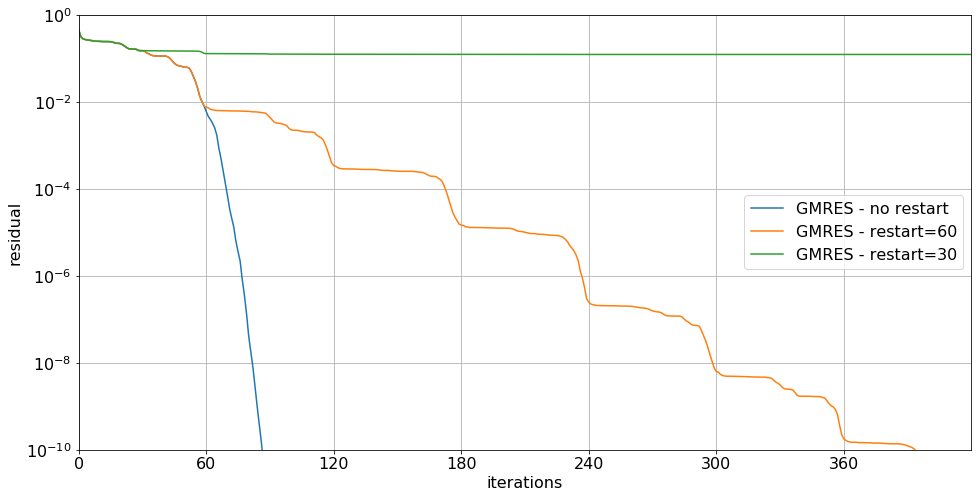

In [46]:
# create a slighty challenging matrix and random rhs
n = 100
np.random.seed(0)
A = np.diagflat(np.random.random(n)) + 10 * np.random.random((n,n))/n
b = np.random.random(n)

# for scipy's gmres we need a slightly different residual monitor (than ResidualMonitor we used for scipy's cg)
# the callback is not called with the current guess x^k every iteration (as this is not always avalaible)
# instead it only provides the norm of the current residual, so we simply add it to the list
class GMRESResidualMonitor:
    def __init__(self):
        self.residuals = []
        
    def __call__(self, rk):
        self.residuals.append(rk)


# without restarts gmres should converge in n iterations, so setting the restart value to n
# it should not have done any restarts
monitor1 = GMRESResidualMonitor()
x, info = spl.gmres(A, b, callback=monitor1, tol=1e-10, restart=n)

# now with a restart of 60
monitor2 = GMRESResidualMonitor()
x, info = spl.gmres(A, b, callback=monitor2, tol=1e-10, restart=60)

# and the default restart of 30
monitor3 = GMRESResidualMonitor()
x, info = spl.gmres(A, b, callback=monitor3, tol=1e-10, restart=30)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
fig.subplots_adjust(hspace=0.4)
ax.semilogy(monitor1.residuals, label='GMRES - no restart')
ax.semilogy(monitor2.residuals, label='GMRES - restart=60')
ax.semilogy(monitor3.residuals, label='GMRES - restart=30')
ax.set_xlabel('iterations')
ax.set_ylabel('residual')
ax.grid()
ax.set_xticks(np.arange(7)*60)
ax.axis([0.,420,1e-10, 1])
ax.legend();

In the convergence graphs above we applied to GMRES to a rather difficult-to-solve system. We observe that without restarts it takes $\approx$ 80 iterations to converge, which is a lot for a system of $n=100$. It seems to take GMRES quite a few iterations before "it gets going", with only slow reduction of the residual in the first 50 iterations. When a restart value of 60 is used, we see that this initial slow convergence is repeated after each restart. For this particular problem if we use scipy's default restart value of 30, the method does not converge at all; The restarts in this case are so disruptive that it does not have sufficient iterations after a restart to recover.

It should be noted that for many practical problems, we may hope to achieve a decent reduction (a few orders of magnitude) of the residual in the first 30 iterations, in particular when GMRES is combined with a suitable preconditioner - so the default value of 30 is not a bad choice. It is however good practice to check that this is the case by monitoring the convergence of the method. If insufficient convergence is observed, one should try to improve this by better preconditioning; If all else fails a higher restart value might be the only remedy.

## Other Krylov Methods
For asymmetric linear systems GMRES is a robust generic method. Without restarts, at the very least convergence is guaranteed, although the number of required iterations can be large. Restarted GMRES gives good performance in many cases (although convergence is no longer guaranteed). There are a number of other Krylov methods for asymmetric systems, which for some specific cases outperform GMRES. None of them however provide the same generic, robust performance as GMRES, and unfortunately it is very hard to say in advance for which specific systems some of the other methods may give better performance. So in practice simply trying out a few different methods may be the best approach of obtaining the best performance. Some methods that are used in practice are: Conjugate Gradient Squared (CGS), BiCGStab, CGNE, CGNR, and Quasi-Minimal Residual (QMR).

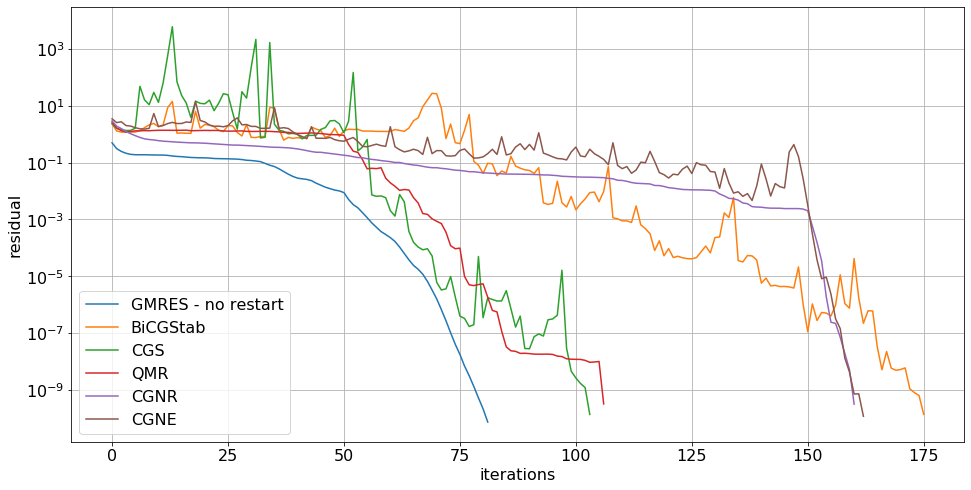

In [47]:
# create a slighty challenging matrix and random rhs
n = 100
np.random.seed(10)
A = np.diagflat(np.random.random(n)) + 10 * np.random.random((n,n))/n
b = np.random.random(n)

# GMRES with no restart
monitor1 = GMRESResidualMonitor()
x, info = spl.gmres(A, b, callback=monitor1, tol=1e-10, restart=n)

# BiCGStab
monitor2 = ResidualMonitor(A, b)
x, info = spl.bicgstab(A, b, callback=monitor2, tol=1e-10)

# CGS
monitor3 = ResidualMonitor(A, b)
x, info = spl.cgs(A, b, callback=monitor3, tol=1e-10)

# QMR
monitor4 = ResidualMonitor(A, b)
x, info = spl.qmr(A, b, callback=monitor4, tol=1e-10)

# CGNR: solve A.T A x = A.T b
# note we solve for x and monitor the actual residual |Ax-b|
monitor5 = ResidualMonitor(A, b)
x, info = spl.cg(A.T @ A, A.T @ b, callback=monitor5, tol=1e-10)

# CGNE: solve A A.T y = b, then x = A.T y
# here we solve for y, so to monitor the actual residual |Ax-b|=|A A^T y -b|
# we need to supply A A^T to the monitor
monitor6 = ResidualMonitor(A @ A.T, b)
x, info = spl.cg(A @ A.T, b, callback=monitor6, tol=1e-10)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
fig.subplots_adjust(hspace=0.4)
ax.semilogy(monitor1.residuals, label='GMRES - no restart')
ax.semilogy(monitor2.residuals, label='BiCGStab')
ax.semilogy(monitor3.residuals, label='CGS')
ax.semilogy(monitor4.residuals, label='QMR')
ax.semilogy(monitor5.residuals, label='CGNR')
ax.semilogy(monitor6.residuals, label='CGNE')

ax.set_xlabel('iterations')
ax.set_ylabel('residual')
ax.grid()
ax.legend();

### BiCG, CGS and BiCGStab (*) <a class="tocSkip"></a>
<div class="optional">
The idea behdind BiCG is to develop in each iteration, in addition to the Krylov Subspace based on the residual $\vec r^{(k)} = \vec b - \mat A\vec x^{(k)}$ of the equation $\mat A\vec x=\vec b$, a dual Krylov Subspace based on the dual equation $\mat A^T\vec x = \vec b$ using the transpose of the matrix $\mat A^T$. We will denote $\vec{\hat r}^{(k)}$ as the residuals of this dual equation, and also construct dual search directions $\vec{\hat p}^{(k)}$. The search directions are constructed much like we did in the Conjugate Gradient algorithm, but instead of demanding orthogonality of the residuals, and $\mat A$-orthogonality for the search directions (as we had in Conjuate gradients):

$$
  \vec r^{(i)} \cdot\vec r^{(j)} = 0, \;\;\;
  \vec p^{(i)} \cdot\mat A\vec p^{(j)} = 0 , \;\;\;
  \text{ for all } i\neq j
$$

we demand

$$
  \vec{\hat r}^{(i)} \cdot\vec r^{(j)} = 0, \;\;\;
  \vec{\hat p}^{(i)} \cdot\mat A\vec p^{(j)} = 0 , \;\;\;
  \text{ for all } i\neq j
$$

For the update of the dual residual $\vec r^{(k)}$ a matrix-vector product with the transpose $\mat A.T$ is needed in addition to the usual matrix-vector product with $\mat A$. This means that the cost per iteration is twice that of Conjugate Gradient, and if, as usual, the matrix-vector product is the dominant cost in GMRES, roughly twice that of a GMRES iteration as well. It should be noted that BiCG is not a stable scheme, it is only used as the theoretical basis of the more stable schemes Conjugate Gradient Squared (CGS) and BiCGStab. In particular *breakdown* of the algorithm occurs if a search directions are found, for which $\vec{\hat p}^{(k)}\mat A\vec p^{(k)}=0$, or when $\vec{\hat r}^{(k)}\cdot\vec r^{(k)}=0$
<br/>
<br/>
In some practical applications, the matrix-vector product with the transpose is not readily available. For instance we might only have access to a function that computes the normal matrix-vector product without explicitly assembling the matrix itself. In this case one can use the <a class="definition" href="#definitions" id="ConjugateGradientSquaredCGS">Conjugate Gradient Squared (CGS)</a> method: a variant of BiCG that avoids the need for the tranpose matrix-vector product, but instead uses two normal matrix vector products.
<br/>
<br/>
If a tranpose matrix-vector product is available (more usual case), the <a class="definition" href="#definitions" id="BiConjugateGradientStabilizedBiCGStab">Bi-Conjugate Gradient Stabilized (BiCGStab)</a> is to be preferred. It adds some stabilisation to the BiCG method that makes it more robust. Neither BiCGStab nor CGS are guaranteed to converge in all cases, breakdown is still very much possible. In some cases, breakdown can be recovered by restarts where the dual residual $\vec{\hat r}$ is reset so that it is no longer orthogonal to the actual residual $\vec r$.
</div>

## Conjugate Gradient on the Normal Equations (*)

<div class="optional">
The idea behind Conjugate Gradient on the Normal Equations is to make use of the fact that if $\mat A$ is invertible then even if $\mat A$ is not symmetric, both $\mat A^T\mat A$ and $\mat A\mat A^T$ are Symmetric and Positive Definite. So by pre-multiplying $\mat A\vec x=\vec b$ with $\mat A^T$, we could solve

$$
  \mat A^T\mat A \vec x = \mat A^T\vec b
$$

using Conjugate Gradient. Note that we don't need to explicitly construct the matrix $\mat A^T\mat A$, instead the matrix-vector product with $\mat A^T\mat A$ can be performed by multiplying the vector with $\mat A$ and $\mat A^T$ in turn.
<br/>
<br/>
An alternative is to solve

$$
  \mat A\mat A^T \vec y = \vec b
$$

first (again using standard CG), and then obtain the solution from $\vec x=\vec A^T\vec y$.
<br/>
<br/>
As we have noted before Conjugate Gradient is a method that minimizes the error in the $\mat A$-norm. In the first case, where the matrix is $\mat A^T\mat A$ that means we are minimizing (try to work this out for yourself)

$$
  \| \vec x - \vec x^* \|_{\mat A^T\mat A} = \| \mat A\vec x-\vec b \|^2
$$

in other words we are minimizing the residual in $\mat A\vec x=\vec b$. This method is therefore called <a class="definition" href="#definitions" id="ConjugateGradientontheNormalequationsminimizingtheResidualCGNR">Conjugate Gradient on the Normal equations minimizing the Residual (CGNR)</a>
<br/>
<br/>
In the second approach, we are minimizing

$$
  \| \vec y - \vec y^* \|_{\mat A\mat A^T} = \| \vec x-\vec x^* \|^2
$$

and this method is therefore called <a class="definition" href="#definitions" id="ConjugateGradientontheNormalequationsminimizingtheErrorCGNE">Conjugate Gradient on the Normal equations minimizing the Error (CGNE)</a>.
<br/>
<br/>
Like BiCGStab, the CGNR and CGNE methods require a matrix-vector product and a transpose matrix-vector product in each iteration. Although the use of Conjugate Gradient makes these methods very robust, their main draw back is that the rate of convergence is determined by the condition number of $\mat A^T\mat A$. For normal matrices, where $\kappa(\mat A^T\mat A)=\kappa(\mat A)^2$, this means that instead of the number of iterations scaling with the square root of the condition number (as it does for CG), the number of required iterations scales linearly with the condition number. Thus, although robust, CGNR and CGNE are slower to converge (also compared with GMRES) in many practical cases.</div>

# List of Definitions
<a id="definitions"/>

* <a class=definition href="#directmethods">direct methods</a>
* <a class=definition href="#fillin">fill-in</a>
* <a class=definition href="#Jacobimethod">Jacobi method</a>
* <a class=definition href="#GaussSeidelmethod">Gauss-Seidel method</a>
* <a class=definition href="#stationarymethods">stationary methods</a>
* <a class=definition href="#SuccessiveOverRelaxationSORmethod">Successive Over-Relaxation (SOR) method.</a>
* <a class=definition href="#backwardGaussSeidel">backward Gauss Seidel</a>
* <a class=definition href="#forwardGaussSeidel">forward Gauss Seidel</a>
* <a class=definition href="#SymmetricSuccessiveOverRelaxationSSOR">Symmetric Successive Over-Relaxation (SSOR)</a>
* <a class=definition href="#ILUmethod">ILU method</a>
* <a class=definition href="#preconditionedsteepestdescent">preconditioned steepest descent</a>
* <a class=definition href="#preconditioning">preconditioning</a>
* <a class=definition href="#preconditioner">preconditioner</a>
* <a class=definition href="#IncompleteCholeskyfactorization">Incomplete Cholesky factorization</a>
* <a class=definition href="#smoothers">smoothers</a>
* <a class=definition href="#GeometricMultigrid">Geometric Multigrid</a>
* <a class=definition href="#AlgebraicMultigridAMG">Algebraic Multigrid (AMG)</a>
* <a class=definition href="#Krylovsubspace">Krylov subspace</a>
* <a class=definition href="#Krylovsubspacemethods">Krylov subspace methods</a>
* <a class=definition href="#GeneralizedMinimumResidualGMRESmethod">Generalized Minimum Residual (GMRES) method</a>
* <a class=definition href="#normalmatrices">normal matrices</a>
* <a class=definition href="#ConjugateGradientSquaredCGS">Conjugate Gradient Squared (CGS)</a>
* <a class=definition href="#BiConjugateGradientStabilizedBiCGStab">Bi-Conjugate Gradient Stabilized (BiCGStab)</a>
* <a class=definition href="#ConjugateGradientontheNormalequationsminimizingtheResidualCGNR">Conjugate Gradient on the Normal equations minimizing the Residual (CGNR)</a>
* <a class=definition href="#ConjugateGradientontheNormalequationsminimizingtheErrorCGNE">Conjugate Gradient on the Normal equations minimizing the Error (CGNE)</a>
